# Zakaria ABDALLAH

# Adversarial examples - Blind spot in representation spaces
### Author: Pietro Gori

As for all TP, answer all questions and fill the code where you see **XXXXXXXXX**

**Deadline**: please verify on the Moodle/Ecampus/web site the deadline

In [1]:
import numpy as np
import random

# pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset, TensorDataset

# torchvision
from torchvision import models,transforms
import torchvision.datasets as Data

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline

import time

In this practical session, you will produce adversarial examples using two strategies to analyse the quality and smoothness of a representation space. We will use the Mnist dataset and a simple network (with 97% accuracy on test though...) so that you can train and test on your own laptop. Same conclusions can be drawn by using larger architectures and more complex datasets (You can try if you want).

Let's start with the first method. Please read first the article [1], in particular from Sectioon 4.

`[1] Szegedy, Christian, Zaremba, Wojciech, Sutskever, Ilya, Bruna, Joan, Erhan, Dumitru, Goodfellow, Ian J.,
and Fergus, Rob. Intriguing properties of neural networks. ICLR, 2014`

We first check if you are using a computer with GPU, CUDA (Nvidia) or MPS (MacBook), or only CPU.

In [2]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
    print ("MPS (MacBook) device found.")
    print('Number of MPS cards: ', torch.mps.device_count())
    print('Total MPS memory {0:.2f} GB'.format(torch.mps.recommended_max_memory()/pow(10,9)))
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print(x)
    print ("CUDA device found.")
    print('Number of GPU cards: ', torch.cuda.device_count(), '\nWhich card GPU?', torch.cuda.get_device_name(0))
    print('Total GPU memory {1:.2f} GB. Free GPU memory {0:.2f} GB'.format(torch.cuda.mem_get_info()[0]/pow(10,9),torch.cuda.mem_get_info()[1]/pow(10,9)))
else:
   device = torch.device("cpu")
   x = torch.ones(1, device=device)
   print(x)
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.5.1+cu121
tensor([1.], device='cuda:0')
CUDA device found.
Number of GPU cards:  1 
Which card GPU? Tesla T4
Total GPU memory 15.84 GB. Free GPU memory 15.71 GB


Here we fix the different seeds to make your algorithm reproducible and we set the hyper-parameters for the classification model we are going to train. You can modify them if you want, but I suggest you keep them like that for now and modify them only AFTER having trained for a first time the model.

In [3]:
# to make the results reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)
torch.mps.manual_seed(10)
random.seed(10)


# Parameters for training model
weight_decay = 0
num_epochs = 5
batch_size=256 # adapted to the Google Colab GPU
learning_rate=0.001
loss_model=nn.CrossEntropyLoss()

We will use the MNIST dataset. Download it from torchvision.

In [4]:
mnist_train = Data.MNIST(root='data/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

train_loader  = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True)

mnist_test = Data.MNIST(root='data/',
                          train=False,
                          transform=transforms.ToTensor(),
                          download=True)

test_loader  = DataLoader(dataset=mnist_test,
                                          batch_size=10000,
                                          shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.61MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



We analyse the data to check the number of samples and their size.

In [5]:
# Print infomration
print("There are ", len (mnist_train), "training images and ", len(mnist_test), "test images")
image_size=list(mnist_train[0][0].squeeze().shape)
print(f"Each image is of shape: {image_size}")  # [28, 28]


There are  60000 training images and  10000 test images
Each image is of shape: [28, 28]


Here we code the model proposed in the article.

**Question**: complete the code so that you can create *A simple fully connected network with one or more hidden layers. We refer to this network as “FC”*. Please code it so that the input_size of the model (i.e. size of the input images), the number and size of hidden layers (e.g., [100,100]) and the output size (i.e., number of possible classes) are parameters of the model. Since we will use the Cross Entropy loss of Pytorch, the model should output the unnormalized logits for each class.

In [6]:
class FullyConnectedNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FullyConnectedNet, self).__init__()
        # Create a list to hold all layers
        layers = []

        # Input layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())  # Activation function

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        # Use nn.Sequential to create the network
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input image to match the input size
        x = x.view(x.size(0), -1)
        # Pass the input through the layers
        return self.model(x)


**Question**: Create one of the model proposed in the article.

In [14]:
input_size = 28 * 28
hidden_sizes = [100, 100]
output_size = 10

# Model
model = FullyConnectedNet(input_size, hidden_sizes, output_size).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Print the model
print(model)


FullyConnectedNet(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


Here we code the training procedure, as commonly done with Pytorch. Please note that we use the Adam optimizer.

In [15]:
def training(model, train_loader, optimizer, num_epochs, loss_model):
  for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):

        # Put images to GPU
        X = images.to(device)
        Y = labels.to(device)

        # Forward pass
        outputs = model(X)
        loss = loss_model(outputs, Y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

And we evaluate it.

In [16]:
def evaluation(model, test_loader):
  model.eval()

  correct = 0
  total = 0

  for images, labels in test_loader:

      X  = images.to(device)
      Y  = labels.to(device)

      outputs = model(X) # array of size [num test images, num classes]

      predicted_class = torch.argmax(outputs.data, dim=1) # faster

      total += len(Y)
      correct += (predicted_class == Y).sum()
  accuracy = 100 * float(correct) / total
  print(f'Accuracy of test images: {accuracy:.2f} %')
  return accuracy



In [17]:
# Training loop
training(model, train_loader, optimizer, num_epochs, loss_model)

Epoch [1/5], Step [100/235], Loss: 0.3157
Epoch [1/5], Step [200/235], Loss: 0.3039
Epoch [2/5], Step [100/235], Loss: 0.1447
Epoch [2/5], Step [200/235], Loss: 0.1521
Epoch [3/5], Step [100/235], Loss: 0.2314
Epoch [3/5], Step [200/235], Loss: 0.1906
Epoch [4/5], Step [100/235], Loss: 0.1605
Epoch [4/5], Step [200/235], Loss: 0.2047
Epoch [5/5], Step [100/235], Loss: 0.1422
Epoch [5/5], Step [200/235], Loss: 0.0466


In [18]:
evaluation(model, test_loader)

Accuracy of test images: 96.44 %


96.44

**Question**: Is the performance good ? Test different architectures (number and size of hidden layers). You can also try different hyper-parameters (weight decay, number of epochs, etc.). Use the "Occam's razor principle" to choose and justify your final model.

In [13]:
hidden_layer_configs = [
    [100, 100],
    [256, 128, 64]
]

weight_decays = [0.001]
learning_rates = [0.001, 0.005]
epochs = [10]

best_accuracy = 0
best_model = None
best_config = None

for hidden_sizes in hidden_layer_configs:
    for wd in weight_decays:
        for lr in learning_rates:
            print(f"Testing config: Hidden sizes={hidden_sizes}, Weight decay={wd}, LR={lr}")
            model = FullyConnectedNet(input_size=28*28, hidden_sizes=hidden_sizes, output_size=10).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

            training(model, train_loader, optimizer, num_epochs=5, loss_model=nn.CrossEntropyLoss())
            acc = evaluation(model, test_loader)

            if acc > best_accuracy:
                best_accuracy = acc
                best_model = model
                best_config = (hidden_sizes, wd, lr)

print(f"best accuracy: {best_accuracy} : config : {best_config}")


Testing config: Hidden sizes=[100, 100], Weight decay=0.001, LR=0.001
Epoch [1/5], Step [100/235], Loss: 0.3650
Epoch [1/5], Step [200/235], Loss: 0.3032
Epoch [2/5], Step [100/235], Loss: 0.2591
Epoch [2/5], Step [200/235], Loss: 0.1265
Epoch [3/5], Step [100/235], Loss: 0.1685
Epoch [3/5], Step [200/235], Loss: 0.1382
Epoch [4/5], Step [100/235], Loss: 0.0645
Epoch [4/5], Step [200/235], Loss: 0.1500
Epoch [5/5], Step [100/235], Loss: 0.1298
Epoch [5/5], Step [200/235], Loss: 0.1208
Accuracy of test images: 96.50 %
Testing config: Hidden sizes=[100, 100], Weight decay=0.001, LR=0.005
Epoch [1/5], Step [100/235], Loss: 0.3253
Epoch [1/5], Step [200/235], Loss: 0.1736
Epoch [2/5], Step [100/235], Loss: 0.1649
Epoch [2/5], Step [200/235], Loss: 0.1001
Epoch [3/5], Step [100/235], Loss: 0.0918
Epoch [3/5], Step [200/235], Loss: 0.0972
Epoch [4/5], Step [100/235], Loss: 0.0689
Epoch [4/5], Step [200/235], Loss: 0.1005
Epoch [5/5], Step [100/235], Loss: 0.0744
Epoch [5/5], Step [200/235], 

The new model achieves higher accuracy but introduces additional complexity with more layers and parameters. While there is slight improvement in accuracy  ( new accuracy of 96.93),  according to Occam's Razor, the simpler architecture (96.44%) is recommended for general use unless the application demands the highest accuracy.

Here, you will code the method proposed in Sec. 4.1 of [1]. I copy/paste it here:

We denote by $f : R^m \rightarrow {1 . . . k}$ a classifier mapping image pixel value vectors to a discrete label set. We also assume that $f$ has an associated continuous loss function denoted by $\text{loss}_f : R^m × {1 . . . k} \rightarrow R^+$. For a given $x \in R^m$ image and target label $l \in {1 . . . k}$, we aim to solve the following box-constrained optimization problem:

• Minimize $||r||_2$ subject to:
1. $f(x + r) = l$
2. $x + r \in [0, 1]^m$


The minimizer $r$ might not be unique, but we denote one such $x + r$ for an arbitrarily chosen minimizer by $D(x, l)$. Informally, $x + r$ is the closest image to $x$ classified as $l$ by $f$. Obviously, $D(x, f(x)) = f(x)$, so this task is non-trivial only if $f(x) \neq l$. In general, the exact computation
of $D(x, l)$ is a hard problem, so we approximate it by using a box-constrained L-BFGS. Concretely, we find an approximation of $D(x, l)$ by performing line-search to find the minimum $c > 0$ for which the minimizer $r$ of the following problem satisfies $f(x + r) = l$.

• Minimize $c|r| + \text{loss}_f (x + r, l)$ subject to $x + r \in [0, 1]^m$

This penalty function method would yield the exact solution for $D(X, l)$ in the case of convex losses, however neural networks are non-convex in general, so we end up with an approximation in this case.

We start by setting the hyper-parameters of the L-BFGS method. Keep them like that for now. You will come back later to change them.

In [19]:
# Parameters adversarial example
index=666 # index test image to use

max_iter_search=300
initial_c = 0.000001  # Initial value of c
max_c = 0.01  # Upper limit for c
mult_c = 1.03 # Multiplicative update of c at each iter c *= mult_c

epsilon_LBFGS = 1e-6  # Small value for line search stopping criterion
max_iter_LBFGS = 100  # Maximum iterations for L-BFGS
lr_LBFGS = 0.1  # Learning rate for L-BFGS

We can plot the chosen image

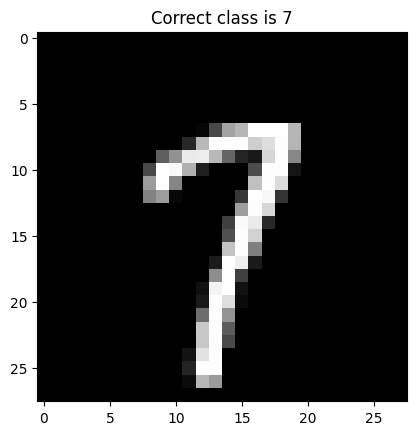

In [20]:
testI, testY = mnist_test.__getitem__(index)
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

I have written a code to plot the original image $x$, the modified image $x+r$ and the residual added $r$.

In [21]:
def plot_results(X, r, Xr, Y, l, fail=True):


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    im1 = axes[0].imshow(X.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[0].set_title(f"Original Image. Correct class is {Y}",fontsize=22)

    im3=axes[2].imshow(r.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
    axes[2].set_title(f"Residual added",fontsize=22)

    if fail:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
        axes[1].set_title(f"Modified Image, FAILED to predict class {l.item()}",fontsize=22)
    else:
        im2=axes[1].imshow(Xr.squeeze().cpu().detach().numpy(), interpolation='nearest', cmap=plt.cm.gray)
        axes[1].set_title(f"Modified Image, PREDICTED class {l.item()}",fontsize=22)

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Intensity (0 to 1)')

    # Show the plots
    plt.show()

Here we will code the proposed method. Complete the code where you see `XXXXXXX`.

Please be advised that the `torch.optim.LBFGS` optimizer is designed to work with a `closure` for computing the loss and gradients multiple times during optimization, which is essential for second-order methods.

The closure is a callable function passed to LBFGS that recomputes the loss and its gradients multiple times during a single optimization step.
To work correctly, we need to call `optimizer.zero_grad()` to clear old gradients before calculating new ones.

Please note that SGD or Adam don't require a closure because they update the parameters based on the current gradient in a single step.

More info here: https://pytorch.org/docs/stable/optim.html

The true class is 3, the new class will be 4
Found c = 0.000001 satisfying f(x + r) = l
Optimization succeeded with c = 0.000001 in 1 iterations
Norm Perturbation |r|: 31986.734375


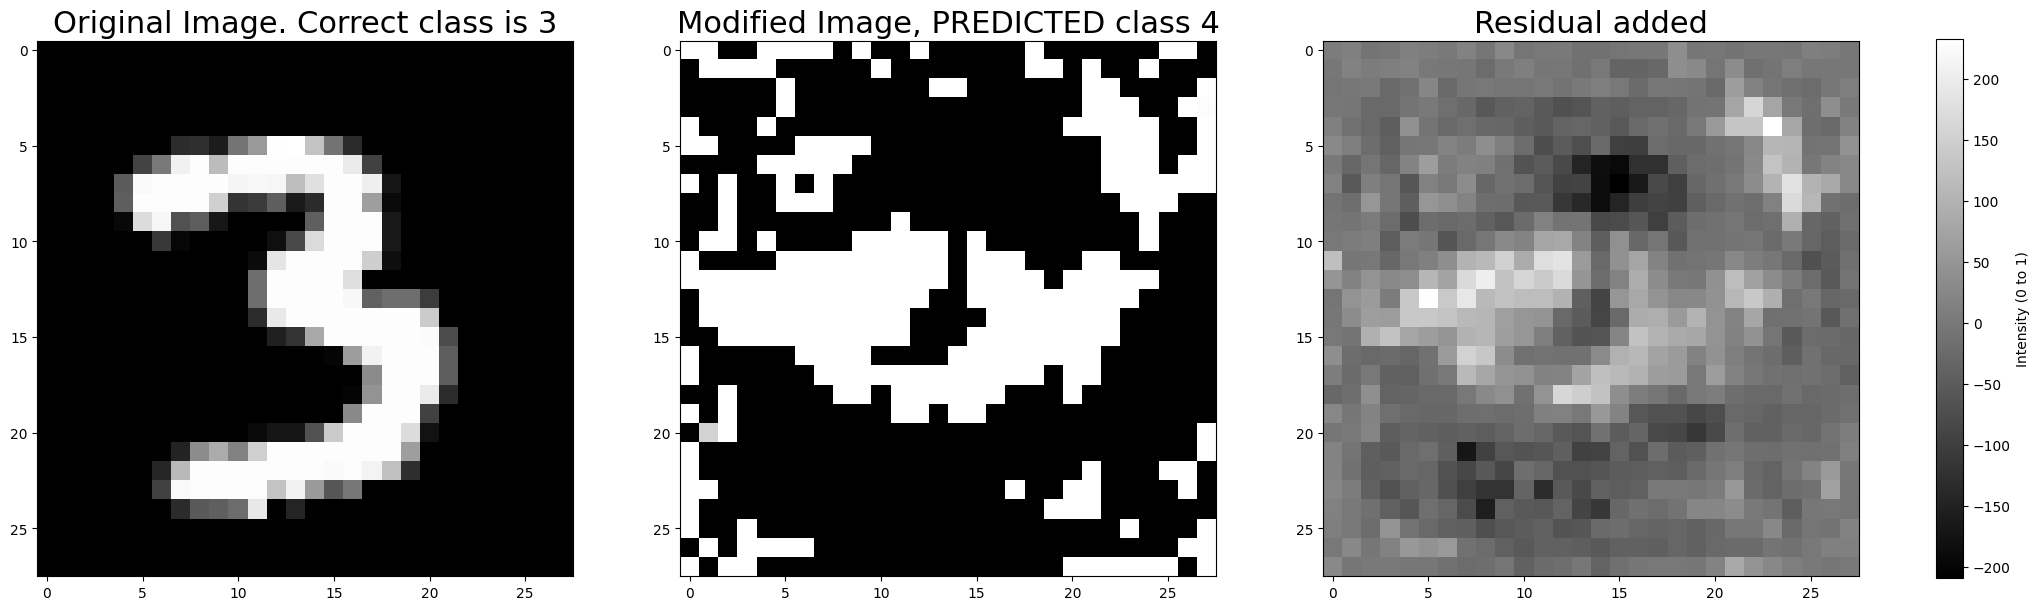

In [34]:
testI = testI.to(device)
r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize r as zero
label = (testY + 1) % 10  # Manually chosen target class label different from true one
l = torch.tensor([label]).to(device)
l = l.view(1)  # To have a batch size equal to 1 and work with CrossEntropy loss
print(f"The true class is {testY}, the new class will be {l[0]}")


# Define the loss function
def objective(c, r, x, l):
    perturbed_image = torch.clamp(x + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
    logits = model(perturbed_image.unsqueeze(0))  # Forward pass through the model
    ce_loss = F.cross_entropy(logits, l)  # Cross-entropy loss
    return c * torch.norm(r, p=2) + ce_loss  # Combine L2 norm of r and CE loss


# Line search to find the minimum c > 0
c = initial_c
iter = 0
while (c <= max_c) and (iter <= max_iter_search):
    # Define the optimizer (Box-Constrained L-BFGS)
    optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, tolerance_grad=epsilon_LBFGS)

    def closure():
        optimizerLBFGS.zero_grad()
        loss = objective(c, r, testI, l)
        loss.backward()
        return loss

    # Perform optimization
    optimizerLBFGS.step(closure)

    # Evaluate the condition f(x + r) = l
    with torch.no_grad():
        x_r = torch.clamp(testI + r, 0, 1)  # Ensure x + r ∈ [0, 1]^m
        pred = model(x_r)
        predicted_label = torch.argmax(pred, dim=1)

    # Check if the condition f(x + r) = l is satisfied
    if predicted_label == l:
        print(f"Found c = {c:.6f} satisfying f(x + r) = l")
        iter = iter + 1
        break
    else:
        iter = iter + 1

    # If not satisfied, increase c
    c *= mult_c  # Adjust step size for line search
    if (iter) % 20 == 0:
        print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

if (c > max_c) or (iter > max_iter_search):
    print("Failed to find c satisfying f(x + r) = l within the maximum limit of c and max number of iter.")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=True)
else:
    print(f"Optimization succeeded with c = {c:.6f} in {iter} iterations")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(testI, r, x_r, testY, l, fail=False)

**QUESTION** Try with different images and different predicted classes (l), does the algorithm always converge ? You can test with different hyper-parameters for c. When it converges, are the images semantically similar to the original one ? Visually, would you say that they should belong to the original or new class ? What's the average distortion (norm of r) ? Would you prefer a small or large value of `c`? Why ?


Testing image 1/3
Image 1: Converged with c = 0.001000

Testing image 2/3
Image 2: Converged with c = 0.001000

Testing image 3/3
Image 3: Converged with c = 0.001000

Results for image 1
Original Label: 7, Target Label: 8, Distortion: 3.367905


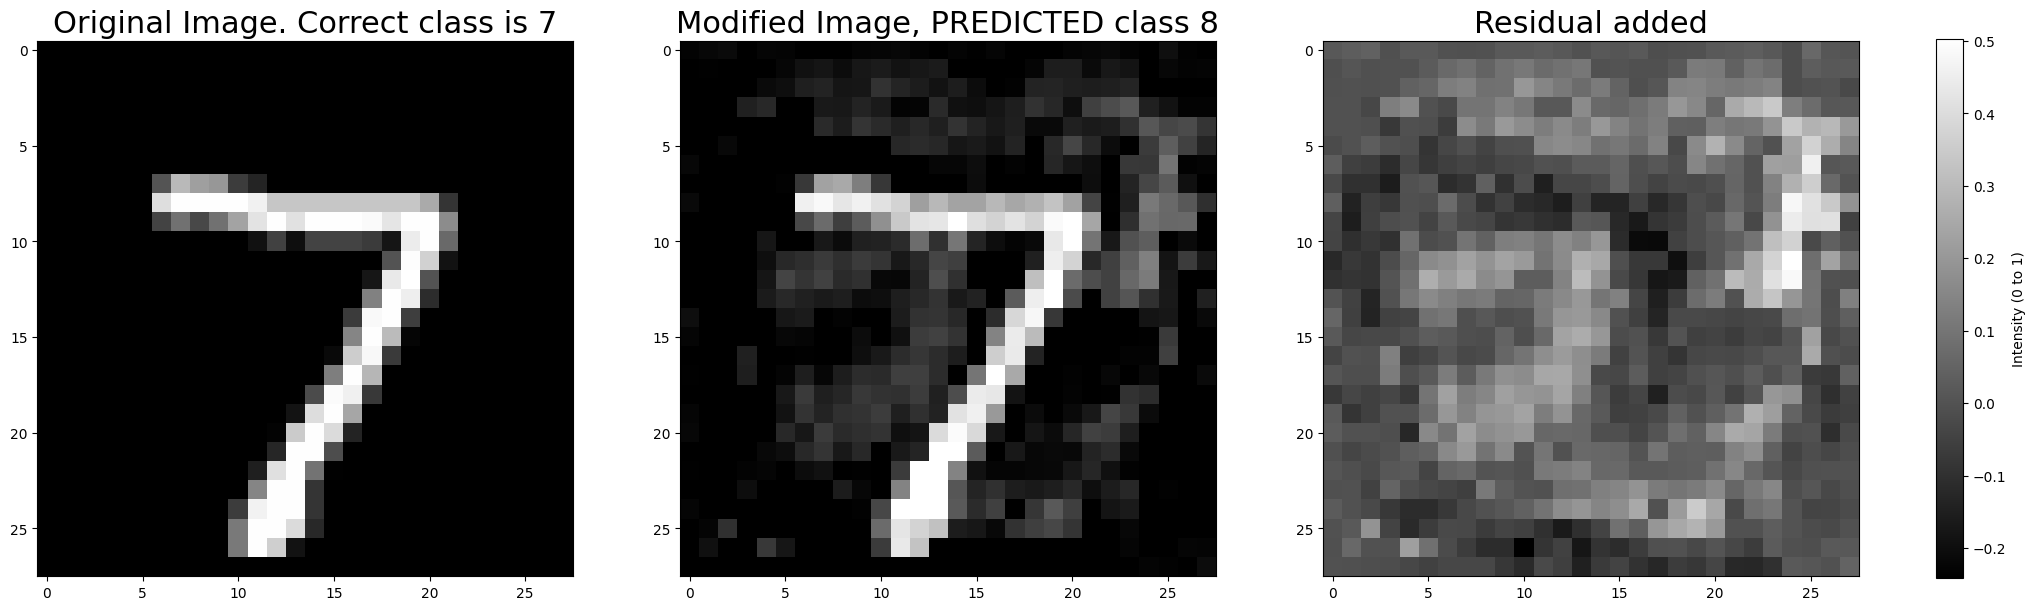


Results for image 2
Original Label: 2, Target Label: 3, Distortion: 3.305274


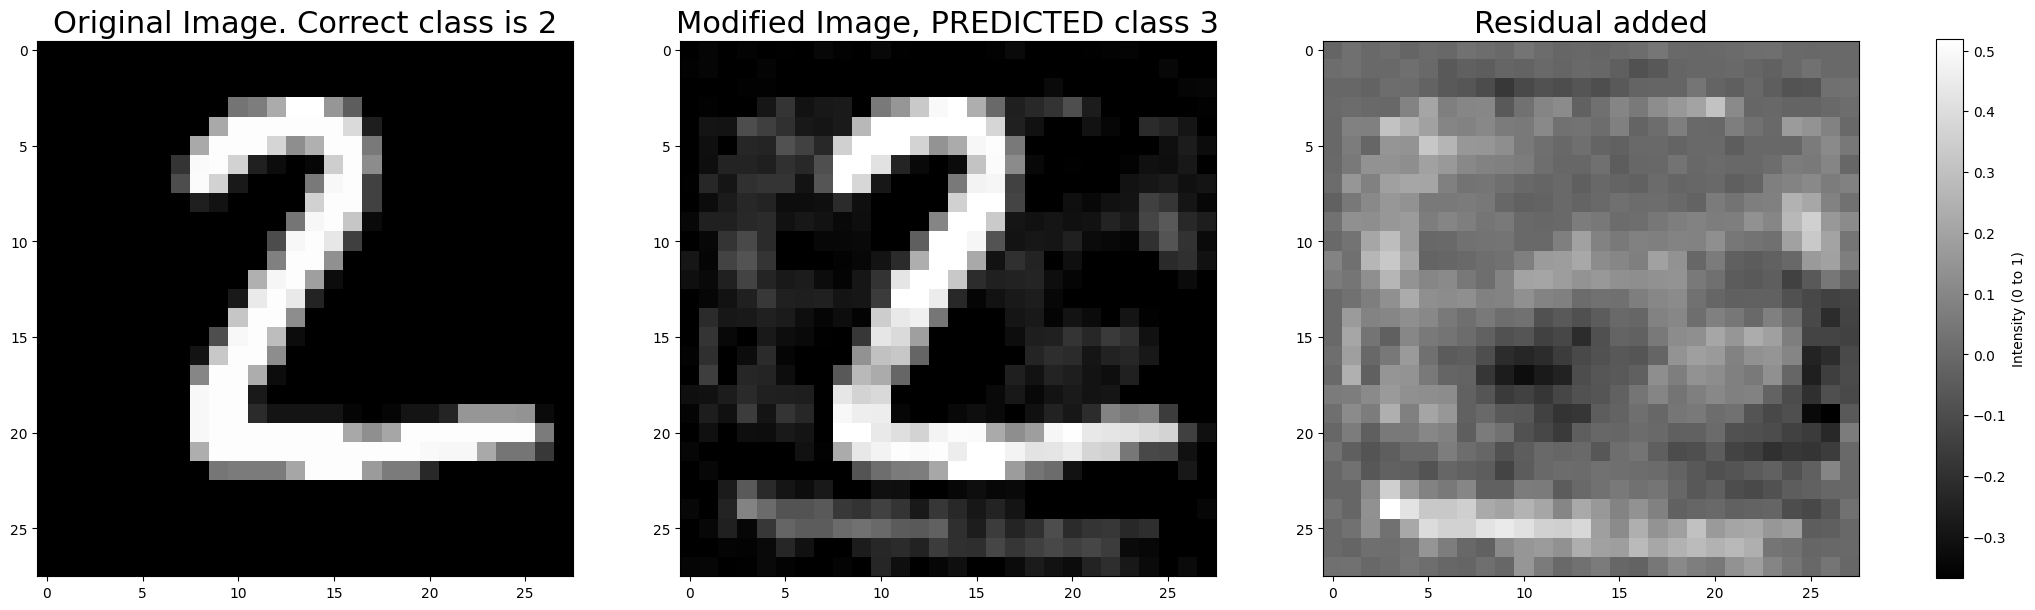


Results for image 3
Original Label: 1, Target Label: 2, Distortion: 3.667780


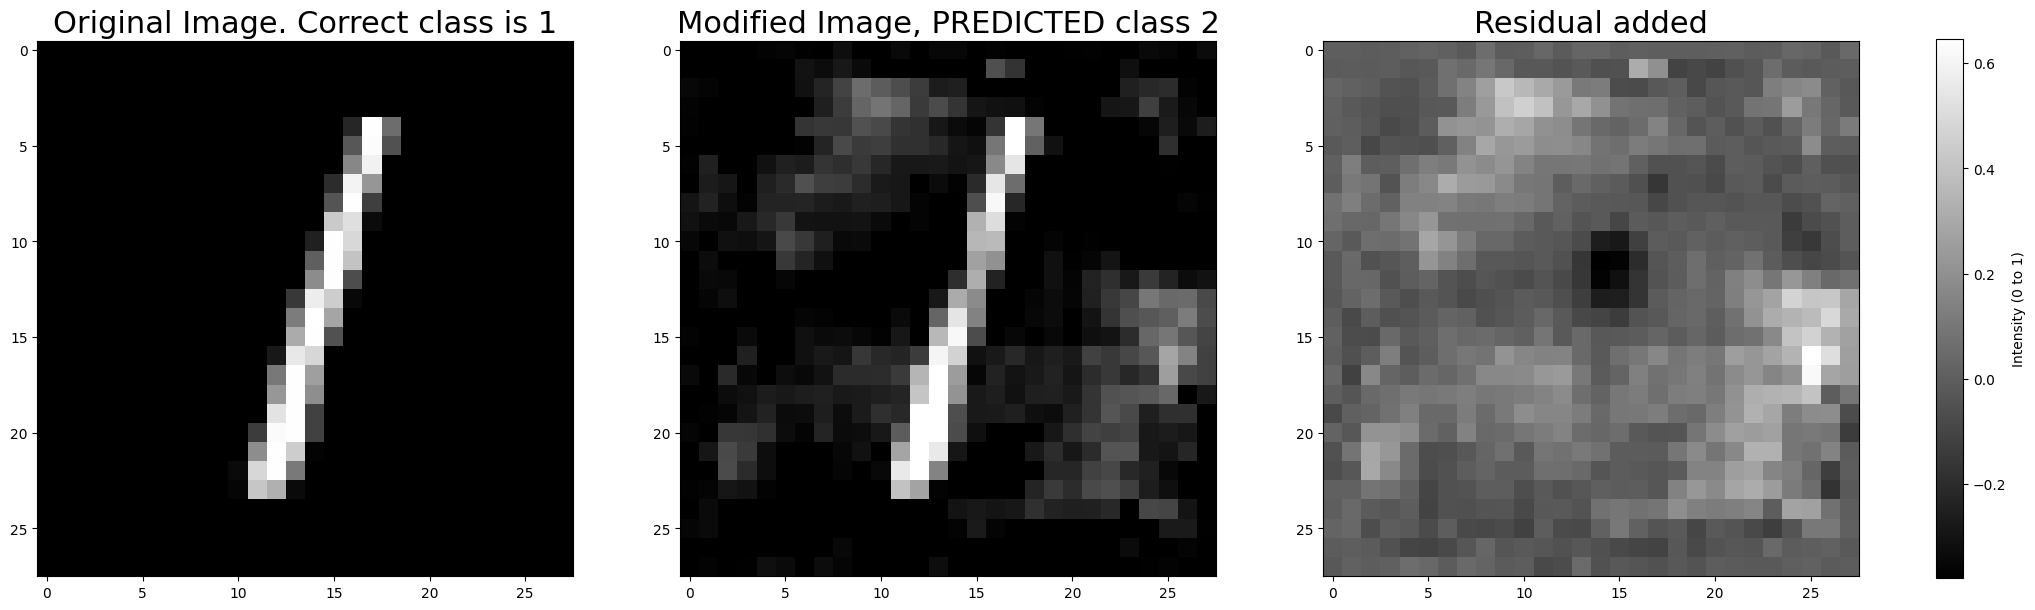

In [40]:
import torch

# Function to evaluate multiple images
def evaluate_adversarial_examples(images, labels, target_classes, model, initial_c, max_c, max_iter_search, lr_LBFGS, max_iter_LBFGS, epsilon_LBFGS, mult_c):
    distortions = []
    results = []

    for i, (testI, testY, target_label) in enumerate(zip(images, labels, target_classes)):
        print(f"\nTesting image {i+1}/{len(images)}")

        # Move input and label to the device
        testI = testI.to(device)
        testY = testY.to(device)
        r = torch.zeros_like(testI, requires_grad=True, device=device)
        l = torch.tensor([target_label]).to(device)
        l = l.view(1)

        c = initial_c
        iter = 0
        converged = False

        while (c <= max_c) and (iter <= max_iter_search):
            optimizerLBFGS = optim.LBFGS([r], lr=lr_LBFGS, max_iter=max_iter_LBFGS, tolerance_grad=epsilon_LBFGS)

            def closure():
                optimizerLBFGS.zero_grad()
                loss = objective(c, r, testI, l)
                loss.backward()
                return loss

            optimizerLBFGS.step(closure)

            with torch.no_grad():
                x_r = torch.clamp(testI + r, 0, 1)
                pred = model(x_r)
                predicted_label = torch.argmax(pred, dim=1)

            if predicted_label == l:
                converged = True
                print(f"Image {i+1}: Converged with c = {c:.6f}")
                distortions.append(torch.norm(r, p=2).item())
                results.append((testI, x_r, r, testY, l))
                break
            else:
                iter += 1

            c *= mult_c
            if iter % 20 == 0:
                print(f'Iter {iter}/{max_iter_search}, Value of c: {c:.6f}')

        if not converged:
            print(f"Image {i+1}: Did not converge within max_iter_search or max_c")
            distortions.append(None)
            results.append((testI, None, None, testY, l))

    return results, distortions

# Prepare test images, labels, and target classes
test_images = []
test_labels = []
target_classes = []

test_loader_1 = DataLoader(
    dataset=mnist_test,
    batch_size=1,  # Each iteration provides a single image
    shuffle=False
)
# Use a larger subset of test samples for evaluation
for idx, (img, label) in enumerate(test_loader_1):
    if len(test_images) >= 3:  # Test on 5 images
        break
    test_images.append(img[0])
    test_labels.append(label[0])
    target_classes.append((label[0] + 1) % 10)  # Different target class


# Run the evaluation
results, distortions = evaluate_adversarial_examples(
    images=test_images,
    labels=test_labels,
    target_classes=target_classes,
    model=model,
    initial_c=1e-3,
    max_c=1e3,
    max_iter_search=100,
    lr_LBFGS=0.1,
    max_iter_LBFGS=20,
    epsilon_LBFGS=1e-5,
    mult_c=10
)

# Analyze the results
for i, (testI, x_r, r, testY, l) in enumerate(results):
    print(f"\nResults for image {i+1}")
    if x_r is not None:
        print(f"Original Label: {testY.item()}, Target Label: {l.item()}, Distortion: {distortions[i]:.6f}")
        plot_results(testI, r, x_r, testY, l, fail=False)
    else:
        print(f"Original Label: {testY.item()}, Target Label: {l.item()}, Did not converge")


In [39]:
# Calculate average distortion
valid_distortions = [d for d in distortions if d is not None]

if valid_distortions:
    avg_distortion = sum(valid_distortions) / len(valid_distortions)
    print(f"Average Distortion: {avg_distortion:.6f}")



Average Distortion: 11.624085



Testing with initial_c=0.01, max_c=0.1, mult_c=1.5

Testing image 1/3
Image 1: Converged with c = 0.010000

Testing image 2/3
Image 2: Converged with c = 0.010000

Testing image 3/3
Image 3: Converged with c = 0.010000

Testing with initial_c=0.001, max_c=0.1, mult_c=1.5

Testing image 1/3
Image 1: Converged with c = 0.001000

Testing image 2/3
Image 2: Converged with c = 0.001000

Testing image 3/3
Image 3: Converged with c = 0.001000

Results for configuration: initial_c=0.01, max_c=0.1, mult_c=1.5
Average Distortion: 2.099209
Image 1: Original Label: 7, Target Label: 8, Distortion: 2.605134


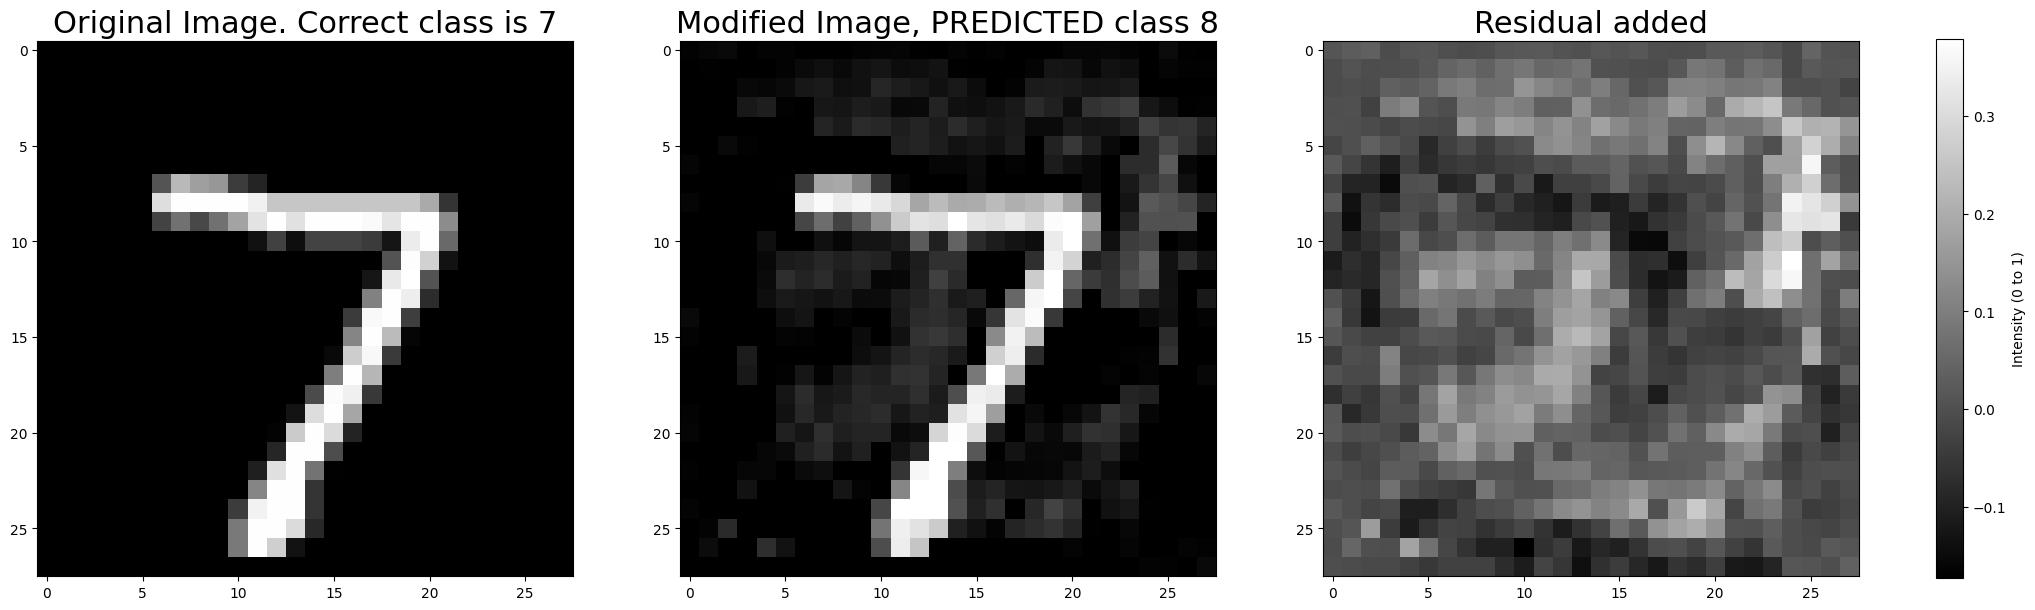

Image 2: Original Label: 2, Target Label: 3, Distortion: 2.116752


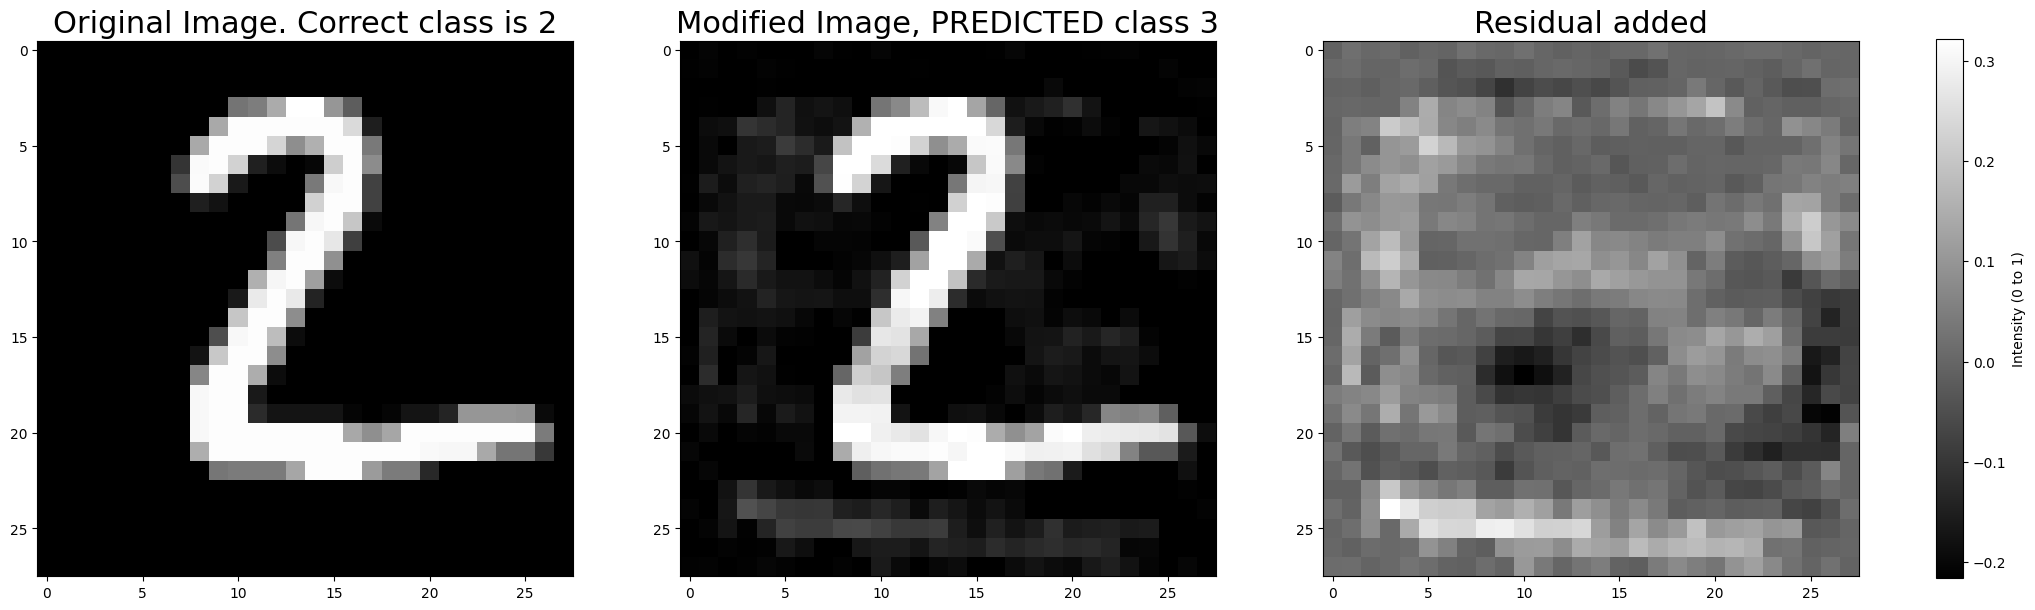

Image 3: Original Label: 1, Target Label: 2, Distortion: 1.575741


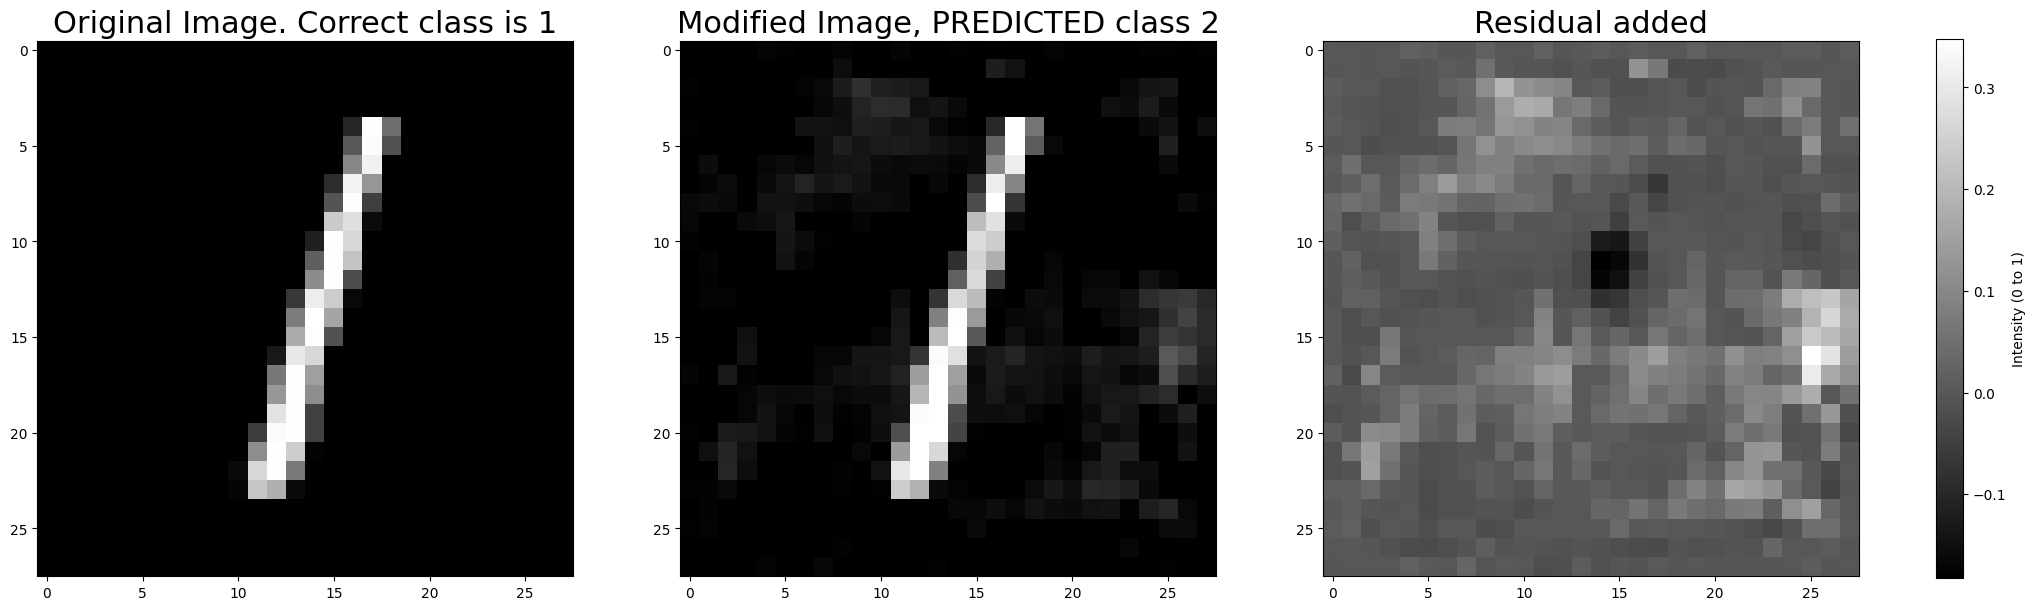


Results for configuration: initial_c=0.001, max_c=0.1, mult_c=1.5
Average Distortion: 3.446986
Image 1: Original Label: 7, Target Label: 8, Distortion: 3.367905


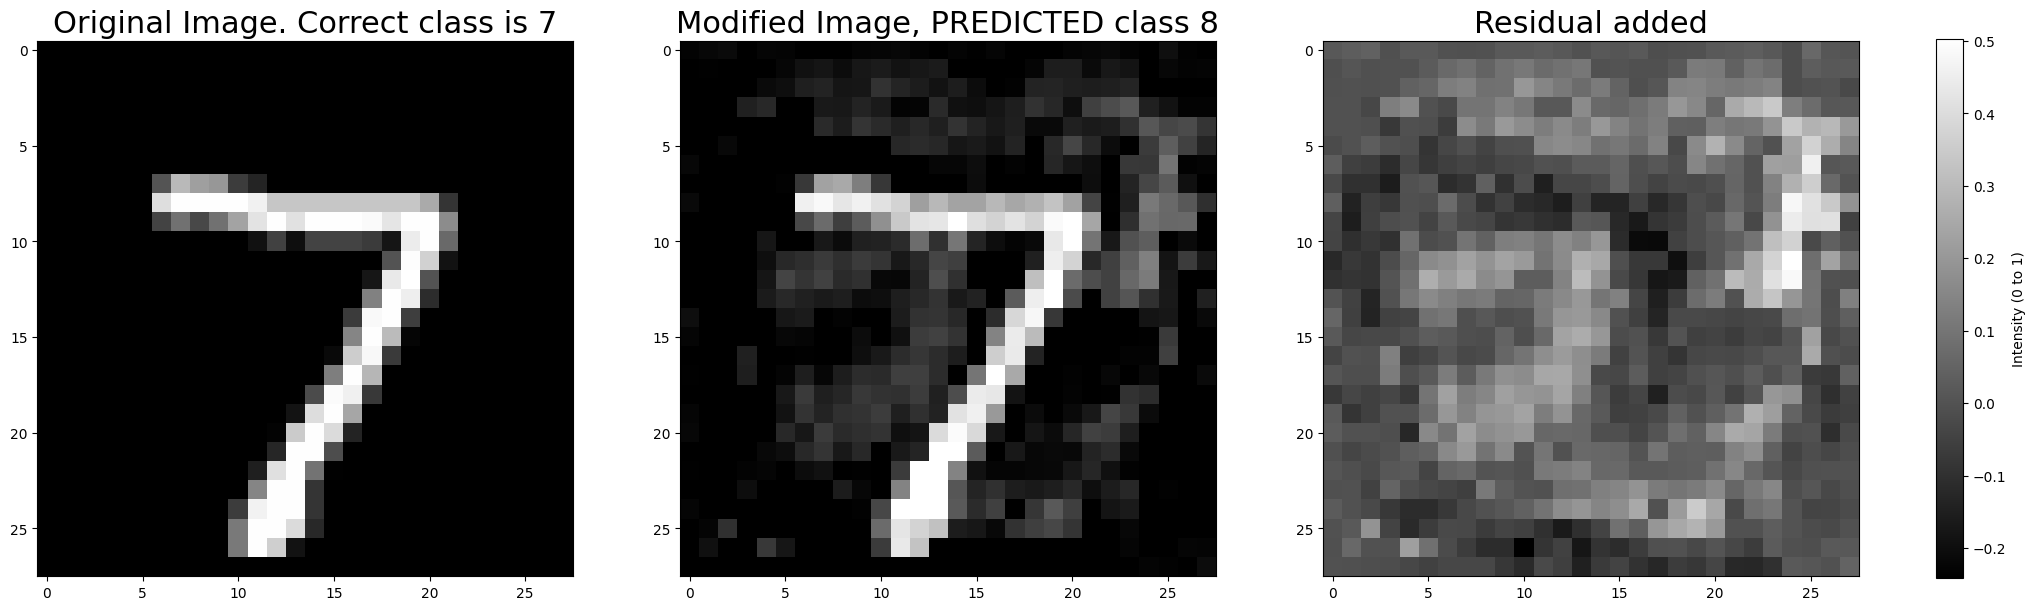

Image 2: Original Label: 2, Target Label: 3, Distortion: 3.305274


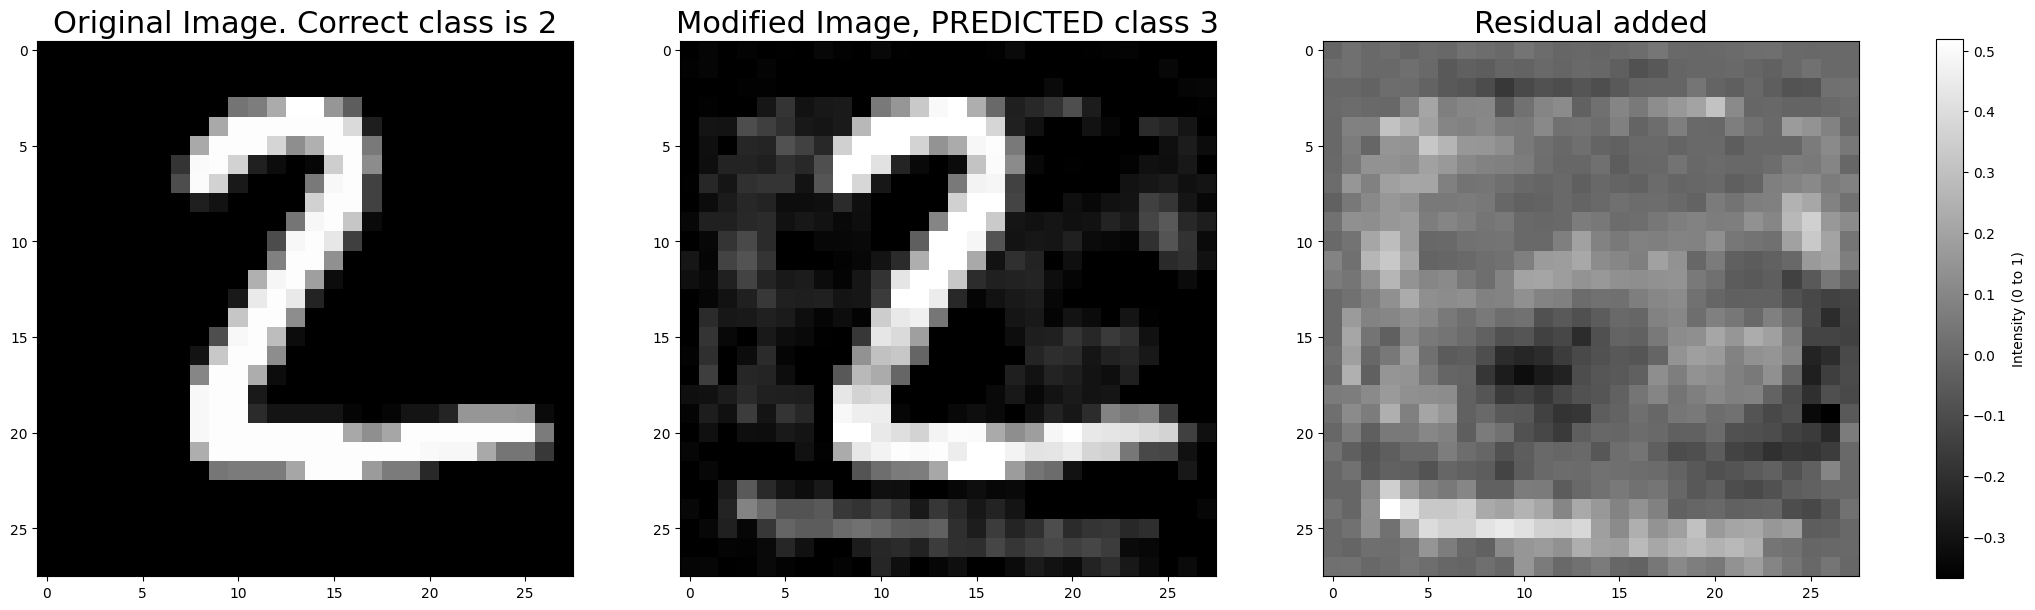

Image 3: Original Label: 1, Target Label: 2, Distortion: 3.667780


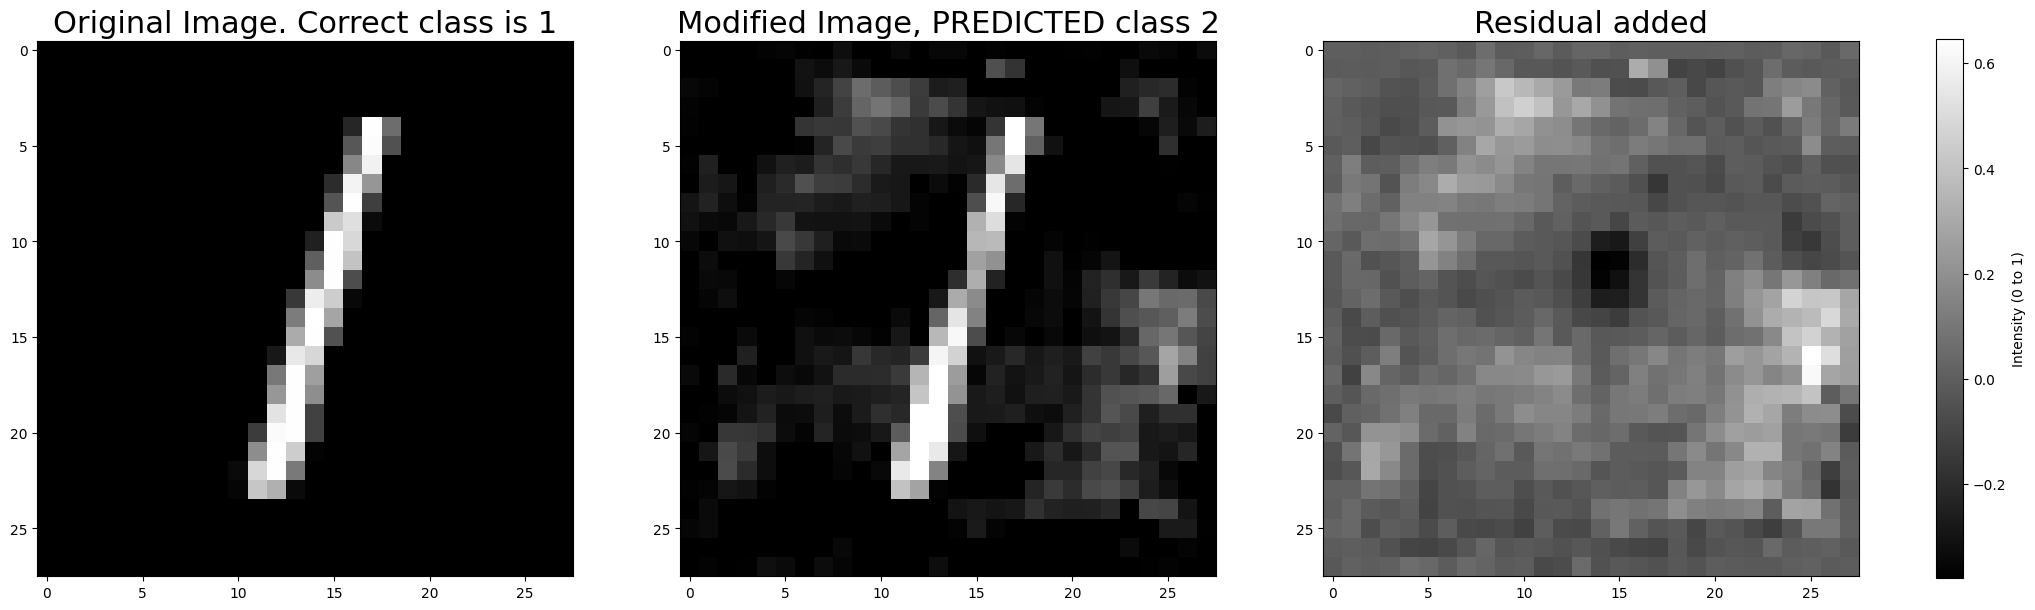

In [47]:
# Hyperparameter ranges for testing different c values
initial_c_values = [1e-2, 1e-3]
max_c_values = [0.1]
mult_c_values = [1.5]

# Dictionary to store results for each configuration
all_results = {}

# Iterate over hyperparameter combinations
for initial_c in initial_c_values:
    for max_c in max_c_values:
        for mult_c in mult_c_values:
            print(f"\nTesting with initial_c={initial_c}, max_c={max_c}, mult_c={mult_c}")

            # Run the evaluation with the current settings
            results, distortions = evaluate_adversarial_examples(
                images=test_images,
                labels=test_labels,
                target_classes=target_classes,
                model=model,
                initial_c=initial_c,
                max_c=max_c,
                max_iter_search=100,
                lr_LBFGS=0.1,
                max_iter_LBFGS=20,
                epsilon_LBFGS=1e-5,
                mult_c=mult_c
            )

            # Store results for this configuration
            config_key = f"initial_c={initial_c}, max_c={max_c}, mult_c={mult_c}"
            all_results[config_key] = {"results": results, "distortions": distortions}

# Visualize and analyze results for all configurations
for config_key, data in all_results.items():
    results = data["results"]
    distortions = data["distortions"]
    print(f"\nResults for configuration: {config_key}")

    valid_distortions = [d for d in distortions if d is not None]
    if valid_distortions:
        avg_distortion = sum(valid_distortions) / len(valid_distortions)
        print(f"Average Distortion: {avg_distortion:.6f}")
    else:
        print("No valid distortions for this configuration.")

    # Plot results for this configuration
    for i, (testI, x_r, r, testY, l) in enumerate(results):
        if x_r is not None:
            print(f"Image {i+1}: Original Label: {testY.item()}, Target Label: {l.item()}, Distortion: {distortions[i]:.6f}")
            plot_results(testI, r, x_r, testY, l, fail=False)


The algorithm always converges. When \( c \) is very small (, \( 0.0000001 \)), the distortion is high (average 11.624) because the penalty on perturbation is too weak, allowing large changes to the image. With higher \( c \) (( 0.01 )), distortion is much lower (average 2.099) because the penalty on perturbation is stronger. Visually, the adversarial images don’t look like the target class but are closer to the original class. Smaller \( c \) leads to unrealistic and  changes, while higher \( c \) produces more subtle  perturbations.

**Question** What if you try with different networks ? Test with al least another network (i.e., change hidden_sizes) and see if the previous conclusions are still confirmed.

Furthermore, check the cross-network performance. This means:
- produce a set of adversarial instances for a given network (samples that are visually similar to the original class but recognised by the network as belonging to a different class)
- check if these adversarial examples are also wrongly classified by the other network

Which conclusions can you draw from these results ? Please comment on that.

In [48]:
# Define two networks with different architectures
original_hidden_sizes = [100, 100]
new_hidden_sizes = [256, 128, 64]

# Original network
model_original = FullyConnectedNet(input_size=28 * 28, hidden_sizes=original_hidden_sizes, output_size=10).to(device)
optimizer_original = optim.Adam(model_original.parameters(), lr=0.001)

# New network
model_new = FullyConnectedNet(input_size=28 * 28, hidden_sizes=new_hidden_sizes, output_size=10).to(device)
optimizer_new = optim.Adam(model_new.parameters(), lr=0.001)


In [49]:
# Train both networks
print("Training original network")
training(model_original, train_loader, optimizer_original, num_epochs=5, loss_model=nn.CrossEntropyLoss())
evaluation(model_original, test_loader)

print("\nTraining new network")
training(model_new, train_loader, optimizer_new, num_epochs=5, loss_model=nn.CrossEntropyLoss())
evaluation(model_new, test_loader)


Training original network
Epoch [1/5], Step [100/235], Loss: 0.2699
Epoch [1/5], Step [200/235], Loss: 0.2790
Epoch [2/5], Step [100/235], Loss: 0.1968
Epoch [2/5], Step [200/235], Loss: 0.2075
Epoch [3/5], Step [100/235], Loss: 0.1098
Epoch [3/5], Step [200/235], Loss: 0.1480
Epoch [4/5], Step [100/235], Loss: 0.0807
Epoch [4/5], Step [200/235], Loss: 0.1186
Epoch [5/5], Step [100/235], Loss: 0.0708
Epoch [5/5], Step [200/235], Loss: 0.0974
Accuracy of test images: 96.56 %

Training new network
Epoch [1/5], Step [100/235], Loss: 0.3421
Epoch [1/5], Step [200/235], Loss: 0.2725
Epoch [2/5], Step [100/235], Loss: 0.2473
Epoch [2/5], Step [200/235], Loss: 0.1583
Epoch [3/5], Step [100/235], Loss: 0.1599
Epoch [3/5], Step [200/235], Loss: 0.0628
Epoch [4/5], Step [100/235], Loss: 0.0700
Epoch [4/5], Step [200/235], Loss: 0.0788
Epoch [5/5], Step [100/235], Loss: 0.0416
Epoch [5/5], Step [200/235], Loss: 0.0803
Accuracy of test images: 96.92 %


96.92

In [50]:
# Generate adversarial examples using the original network
print("\nGenerating adversarial examples for the original network")
adversarial_results, adversarial_distortions = evaluate_adversarial_examples(
    images=test_images,
    labels=test_labels,
    target_classes=target_classes,
    model=model_original,
    initial_c=0.01,
    max_c=0.1,
    max_iter_search=100,
    lr_LBFGS=0.1,
    max_iter_LBFGS=20,
    epsilon_LBFGS=1e-5,
    mult_c=1.5
)

# Analyze results for the original network
print("\nAdversarial results for the original network:")
for i, (testI, x_r, r, testY, l) in enumerate(adversarial_results):
    if x_r is not None:
        print(f"Image {i+1}: Original Label: {testY.item()}, Target Label: {l.item()}, Distortion: {adversarial_distortions[i]:.6f}")



Generating adversarial examples for the original network

Testing image 1/3
Image 1: Converged with c = 0.010000

Testing image 2/3
Image 2: Converged with c = 0.010000

Testing image 3/3
Image 3: Converged with c = 0.010000

Adversarial results for the original network:
Image 1: Original Label: 7, Target Label: 8, Distortion: 2.605134
Image 2: Original Label: 2, Target Label: 3, Distortion: 2.116752
Image 3: Original Label: 1, Target Label: 2, Distortion: 1.575741


In [51]:
# Evaluate cross-network performance
print("\nTesting adversarial examples from the original network on the new network")
transfer_misclassifications = 0

for i, (testI, x_r, _, testY, _) in enumerate(adversarial_results):
    if x_r is not None:  # Only use successfully generated adversarial examples
        with torch.no_grad():
            pred = model_new(x_r)
            predicted_label = torch.argmax(pred, dim=1)
            if predicted_label.item() != testY.item():
                transfer_misclassifications += 1
                print(f"Adversarial Example {i+1}: Misclassified by new network. Predicted: {predicted_label.item()}, True: {testY.item()}")
            else:
                print(f"Adversarial Example {i+1}: Correctly classified by new network.")

# Calculate transfer success rate
transfer_success_rate = transfer_misclassifications / len(adversarial_results) * 100
print(f"\nTransfer success rate: {transfer_success_rate:.2f}%")



Testing adversarial examples from the original network on the new network
Adversarial Example 1: Misclassified by new network. Predicted: 8, True: 7
Adversarial Example 2: Misclassified by new network. Predicted: 3, True: 2
Adversarial Example 3: Misclassified by new network. Predicted: 2, True: 1

Transfer success rate: 100.00%


The new, bigger network was completely fooled by adversarial examples from the first network. Both networks, trained on the same dataset and sharing similar architectures, have overlapping decision boundaries, and adversarial examples exploit these shared weaknesses. This highlights that increasing network size alone does not improve robustness against adversarial attacks.

Instead than using L-BFGS to find adversarial examples we could also use a backpropagation method such as Adam, where you could optimize only r or both r and c.

**Question** Change the previous code to use Adam instead than L-BFGS for the optimization. This means that you don't do anymore a line-search to find the minimum $c$ (no more closure). You can either fix $c$ and estimate only $r$ or estimate both. Try these two solutions and comment on that. Does it work properly ? If not, try to change the loss function. Would you add a regularization term ? If yes, which one and why ? Does it work better ? Would you minimize or maximize c ? Please comment on that.

In [56]:
# Modified adversarial optimization with Adam
def adversarial_optimization_adam(model, testI, testY, target_label, optimize_c=False, fixed_c=fixed_c, lr_adam=lr_adam, max_iter_adam=max_iter_adam, reg_lambda=0.01):
    # Move testI to the same device as the model
    testI = testI.to(device)
    r = torch.zeros_like(testI, requires_grad=True, device=device)  # Initialize perturbation
    c = torch.tensor(fixed_c, requires_grad=optimize_c, device=device)  # Initialize c
    l = torch.tensor([target_label], device=device).view(1)  # Target label

    print(f"True class: {testY}, Target class: {l[0]}")

    # Check initial prediction
    with torch.no_grad():
        pred = model(testI)
        predicted_label = torch.argmax(pred, dim=1)
        print(f"Initial prediction: {predicted_label.item()}, Target: {l.item()}")
        if predicted_label.item() == l.item():
            print("Target class already achieved.")
            return r, testI, True, fixed_c, 0

    params = [r] + ([c] if optimize_c else [])
    optimizer = optim.Adam(params, lr=lr_adam)

    iter_count, success = 0, False
    for _ in range(max_iter_adam):
        optimizer.zero_grad()

        x_r = torch.clamp(testI + r, 0, 1)  # Perturbed image
        logits = model(x_r)

        target_loss = nn.CrossEntropyLoss()(logits, l)  # Target loss
        reg_loss = reg_lambda * torch.norm(r, p=2)  # Regularization

        loss = (c * target_loss if optimize_c else fixed_c * target_loss) + reg_loss
        loss.backward()
        optimizer.step()

        # Check if target class achieved
        with torch.no_grad():
            pred = model(x_r)
            if torch.argmax(pred, dim=1).item() == l.item():
                print(f"Success at iteration {iter_count + 1}, Norm: {torch.norm(r, p=2):.4f}")
                success = True
                break

        iter_count += 1
        if iter_count % 20 == 0:
            print(f"Iter {iter_count}, Loss: {loss.item():.6f}, Norm: {torch.norm(r, p=2):.4f}")

    return r, x_r, success, c.item() if optimize_c else fixed_c, iter_count


In [57]:
# Example with fixed c
r, x_r, success, c_value, iterations = adversarial_optimization_adam(
    model=model_original,
    testI=test_images[0],
    testY=test_labels[0],
    target_label=(test_labels[0] + 1) % 10,
    optimize_c=False,  # Fixed c
    fixed_c=0.001,
    lr_adam=0.01,
    max_iter_adam=300,
    reg_lambda=0.01
)

# Example with optimized c
r, x_r, success, c_value, iterations = adversarial_optimization_adam(
    model=model_original,
    testI=test_images[0],
    testY=test_labels[0],
    target_label=(test_labels[0] + 1) % 10,
    optimize_c=True,  # Optimize c
    lr_adam=0.01,
    max_iter_adam=300,
    reg_lambda=0.01
)


True class: 7, Target class: 8
Initial prediction: 7, Target: 8
Iter 20, Loss: 0.011522, Norm: 0.7293
Iter 40, Loss: 0.011432, Norm: 0.6223
Iter 60, Loss: 0.011422, Norm: 0.6441
Iter 80, Loss: 0.011419, Norm: 0.6340
Iter 100, Loss: 0.011427, Norm: 0.6346
Iter 120, Loss: 0.011424, Norm: 0.6360
Iter 140, Loss: 0.011426, Norm: 0.6357
Iter 160, Loss: 0.011427, Norm: 0.6362
Iter 180, Loss: 0.011421, Norm: 0.6356
Iter 200, Loss: 0.011424, Norm: 0.6360
Iter 220, Loss: 0.011421, Norm: 0.6351
Iter 240, Loss: 0.011429, Norm: 0.6356
Iter 260, Loss: 0.011425, Norm: 0.6377
Iter 280, Loss: 0.011423, Norm: 0.6355
Iter 300, Loss: 0.011425, Norm: 0.6353
True class: 7, Target class: 8
Initial prediction: 7, Target: 8
Iter 20, Loss: -4.456554, Norm: 2.9658
Iter 40, Loss: -16.628782, Norm: 6.9699
Iter 60, Loss: -38.457561, Norm: 11.4991
Iter 80, Loss: -70.858047, Norm: 16.3712
Iter 100, Loss: -95.341461, Norm: 19.1655
Iter 120, Loss: -116.002129, Norm: 19.8297
Iter 140, Loss: -135.312759, Norm: 19.9490
It

Optimizing $r$ while fixing $c$ worked well, producing a valid adversarial example with a small perturbation norm ($\|r\| \approx 0.63$).

In contrast, optimizing both $r$ and $c$ led to instability, resulting in a large perturbation norm ($\|r\| \approx 19.54$) and no convergence.

To address this, adding a regularization term with a hyperparameter $\lambda$ could help stabilize the optimization process for both $r$ and $c$.

In [58]:
def adversarial_optimization_adam_regularized(
    model, testI, testY, target_label, optimize_c=True, fixed_c=0.001, lr_adam=0.01,
    max_iter_adam=300, reg_lambda=0.01, c_bounds=(1e-6, 0.01)
):
    r = torch.zeros_like(testI, requires_grad=True, device=device)
    c = torch.tensor(fixed_c, requires_grad=optimize_c, device=device)
    l = torch.tensor([target_label]).to(device).view(1)

    print(f"The true class is {testY}, the new class will be {l[0]}")

    # Check initial prediction
    with torch.no_grad():
        pred = model(testI)
        predicted_label = torch.argmax(pred, dim=1)
        print(f"Initial prediction: {predicted_label.item()}, Target label: {l.item()}")

    if predicted_label.item() == l.item():
        print("The initial prediction already matches the target label. No optimization needed.")
        return r, testI, True, fixed_c, 0

    params = [r]
    if optimize_c:
        params.append(c)
    optimizer = optim.Adam(params, lr=lr_adam)

    success = False
    for iter_count in range(max_iter_adam):
        optimizer.zero_grad()

        # Compute the loss
        x_r = torch.clamp(testI + r, 0, 1)
        logits = model(x_r)
        target_loss = nn.CrossEntropyLoss()(logits, l)
        reg_loss = reg_lambda * torch.norm(r, p=2)
        loss = (c * target_loss + reg_loss) if optimize_c else (fixed_c * target_loss + reg_loss)

        loss.backward()
        optimizer.step()

        # Clamp c if optimizing
        if optimize_c:
            with torch.no_grad():
                c.clamp_(*c_bounds)

        # Evaluate success
        with torch.no_grad():
            pred = model(x_r)
            predicted_label = torch.argmax(pred, dim=1)
            if predicted_label.item() == l.item():
                print(f"Success at iteration {iter_count + 1}: Adversarial example found with norm {torch.norm(r, p=2):.4f}")
                success = True
                break

        if iter_count % 20 == 0:
            print(f'Iter {iter_count}/{max_iter_adam}, Loss: {loss.item():.6f}, Norm of r: {torch.norm(r, p=2):.4f}')

    return r, x_r, success, c.item() if optimize_c else fixed_c, iter_count


Optimizing r with fixed c:
The true class is 1, the new class will be 2
Initial prediction: 1, Target label: 2
Iter 0/300, Loss: 0.006098, Norm of r: 0.2800
Success at iteration 5: Adversarial example found with norm 1.0114

Optimizing both c and r:
The true class is 1, the new class will be 2
Initial prediction: 1, Target label: 2
Iter 0/300, Loss: 0.006098, Norm of r: 0.2800
Iter 20/300, Loss: 0.000214, Norm of r: 0.1839
Iter 40/300, Loss: 0.000056, Norm of r: 0.0483
Iter 60/300, Loss: 0.000023, Norm of r: 0.0174
Iter 80/300, Loss: 0.000017, Norm of r: 0.0111
Iter 100/300, Loss: 0.000018, Norm of r: 0.0109
Iter 120/300, Loss: 0.000018, Norm of r: 0.0086
Iter 140/300, Loss: 0.000015, Norm of r: 0.0079
Iter 160/300, Loss: 0.000014, Norm of r: 0.0090
Iter 180/300, Loss: 0.000018, Norm of r: 0.0068
Iter 200/300, Loss: 0.000015, Norm of r: 0.0079
Iter 220/300, Loss: 0.000015, Norm of r: 0.0091
Iter 240/300, Loss: 0.000015, Norm of r: 0.0075
Iter 260/300, Loss: 0.000014, Norm of r: 0.0094

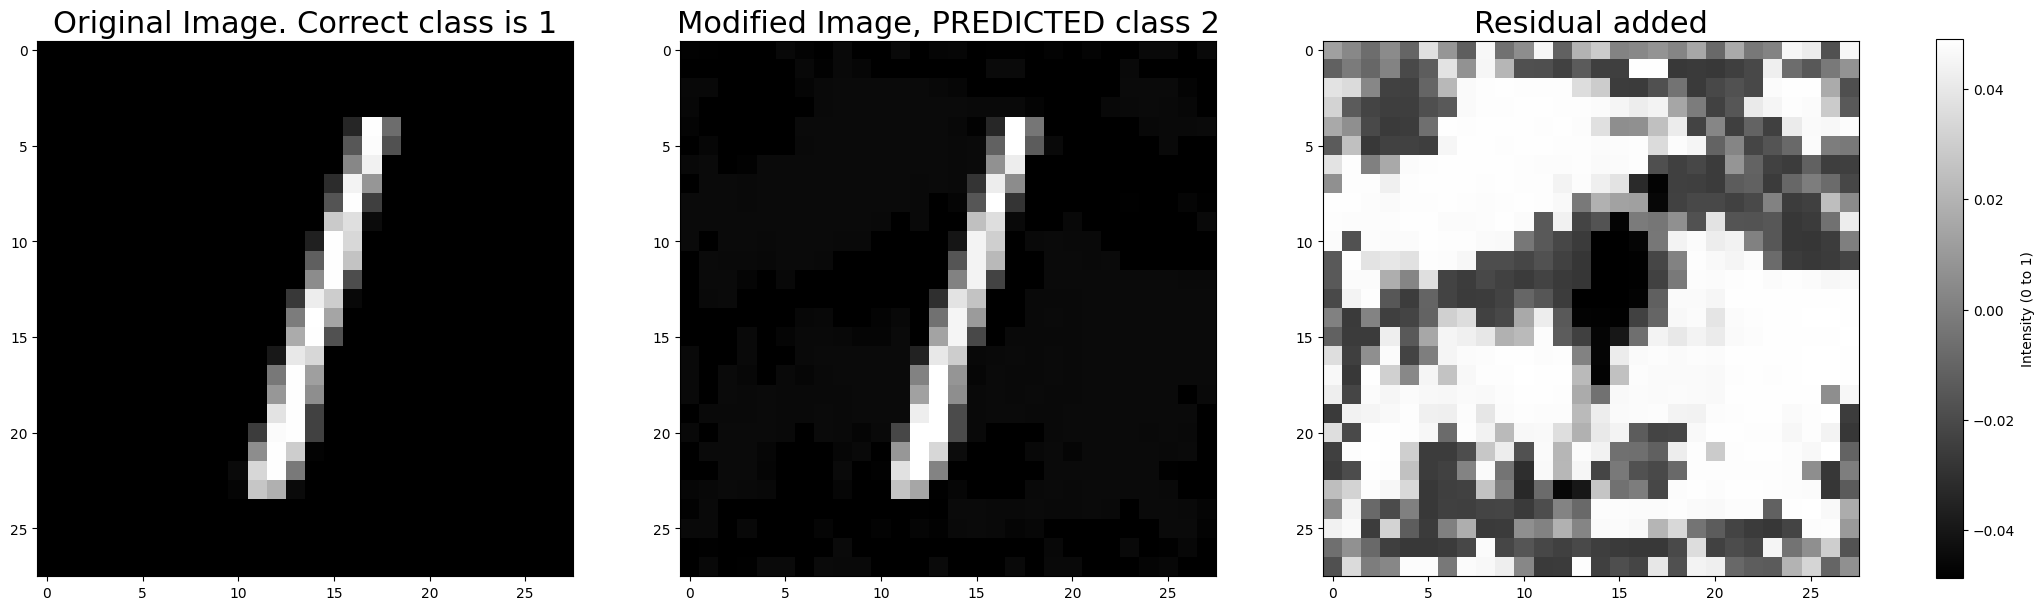

Optimizing c: Failed to find adversarial example within the iteration limit.


In [63]:
# Dynamically assign a target label different from the true class
current_label = torch.argmax(model(testI.to(device)), dim=1).item()
target_label = (current_label + 1) % 10  # Choose a different label (modulo ensures valid class)

# Adversarial optimization with fixed c
print("\nOptimizing r with fixed c:")
r_fixed_c, x_r_fixed_c, success_fixed_c, c_fixed, iter_fixed = adversarial_optimization_adam_regularized(
    model=model.to(device),
    testI=testI.to(device),
    testY=testY,
    target_label=target_label,
    optimize_c=False,
    reg_lambda=0.001
)

# Adversarial optimization optimizing both c and r
print("\nOptimizing both c and r:")
r_opt_c, x_r_opt_c, success_opt_c, c_opt, iter_opt = adversarial_optimization_adam_regularized(
    model=model.to(device),
    testI=testI.to(device),
    testY=testY,
    target_label=target_label,
    optimize_c=True,
    reg_lambda=0.001
)

# Visualize results for fixed c
if success_fixed_c:
    print(f"Fixed c: Optimization succeeded in {iter_fixed} iterations with c = {c_fixed:.6f}")
    plot_results(
        X=testI,
        r=r_fixed_c,
        Xr=x_r_fixed_c,
        Y=testY,
        l=torch.tensor(target_label, device=device),
        fail=not success_fixed_c
    )
else:
    print("Fixed c: Failed to find adversarial example within the iteration limit.")

# Visualize results for optimized c
if success_opt_c:
    print(f"Optimizing c: Optimization succeeded in {iter_opt} iterations with c = {c_opt:.6f}")
    plot_results(
        X=testI,
        r=r_opt_c,
        Xr=x_r_opt_c,
        Y=testY,
        l=torch.tensor(target_label, device=device),
        fail=not success_opt_c
    )
else:
    print("Optimizing c: Failed to find adversarial example within the iteration limit.")


Using Adam optimization with fixed $c$ worked well, converging in 4 iterations with a small perturbation norm ($\|r\| = 1.0114$), producing valid adversarial examples.

However, optimizing both $c$ and $r$ failed to converge due to instability in $c$. Adding a regularization term or clamping $c$ could improve stability. Fixing $c$ is the more reliable approach.

# Fast Gradient Sign Attack (FGSM)

Another famous method to create adversarial examples is Fast Gradient Sign Attack (FGSM). Let $\theta$ be the parameters of a model, x the input image to the model, y its class and J(θ, x, y) the cost used to train the neural network. Usually, when training a model, we compute the gradient of the cost function with respect to the parameters of the model and update them based on the oppositve (i.e., negative) direction of the gradient to decrease the loss. Here, we can replicate the same reasoning but using the pixel values of the input image instead than the model's parameters and using the gradient direction (i.e., positve) to actually maximize the loss. The idea is thus to modify the pixel values so that the loss is maximized and not minimized. In this way, the perturbation should change the image so that it will be misclassified by the model. In order to keep the changes small, possibly imperceptible to naked eye, we only use the sign of the gradient and multiply it by a small $\epsilon$ value. Mathematically, the adversarial example is estimated using:
 $$x_r =x + \epsilon \text{sign}(\Delta_x J(\theta, x, y))$$

 The gradient can easily be computed using backpropagation (Adam).


[*]` Ian J. Goodfellow, Jonathon Shlens & Christian Szegedy Explaining and harnessing adversarial examples. ICLR. 2015`

Let's load an image.

In [64]:
# Parameters
index=10
testI, testY = mnist_test.__getitem__(index)
X = testI.unsqueeze(0).to(device)
print(X.shape)
X.requires_grad = True # Important for attack
Y=torch.tensor([testY]).to(device)

torch.Size([1, 1, 28, 28])


And plot it.

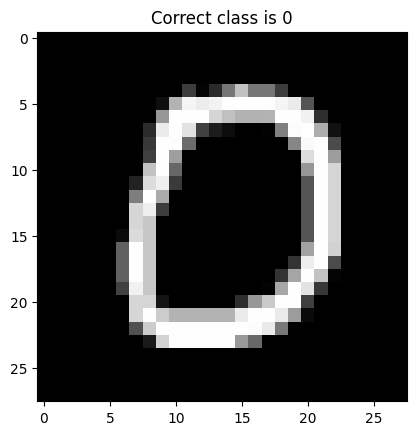

In [65]:
fig = plt.imshow(testI.squeeze(), interpolation='nearest', cmap=plt.cm.gray)
plt.title(f"Correct class is {testY}")
plt.show()

Complete the code by fixing a `eps`value.

Original Class: 0, Perturbed Class: 2
Optimization successful
Norm Perturbation |r|: 78.4000015258789


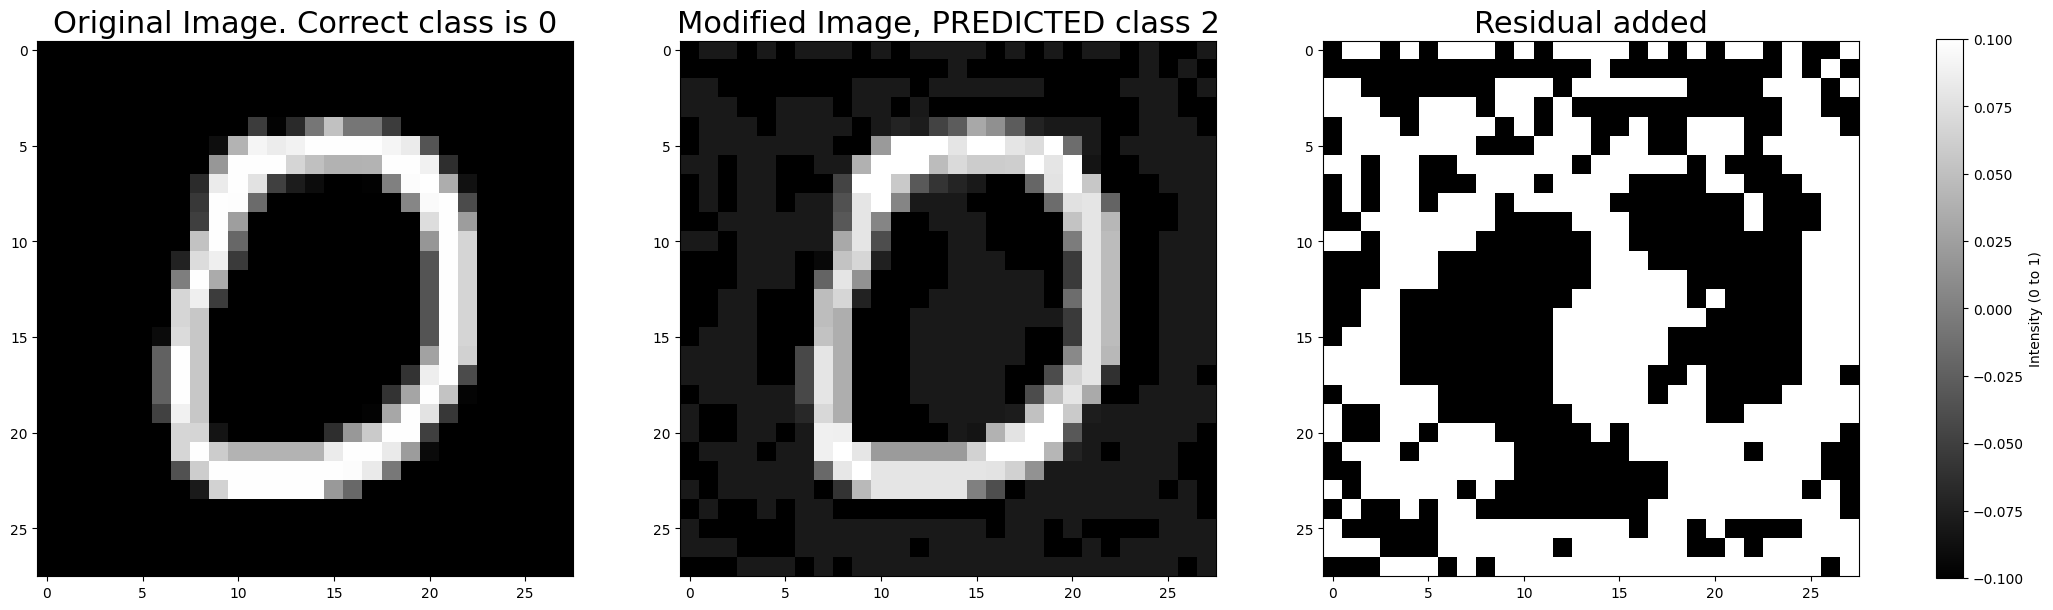

In [66]:
# Fix epsilon value
eps = 0.1  # Perturbation size

# Forward pass of X through the model
pred_original = model(X)
original_class = torch.argmax(pred_original, dim=1)  # Predicted original class

# Compute loss
cost = nn.CrossEntropyLoss()(pred_original, Y)  # Loss function

# Zero existing (previous) gradients
model.zero_grad()

# Compute gradients
cost.backward()

# FGSM attack code
Xr = X + eps * X.grad.data.sign()
Xr = torch.clamp(Xr, 0, 1)

# Re-classify the perturbed image
pred_perturbed = model(Xr)
perturbed_class = torch.argmax(pred_perturbed, dim=1)

# Print results
print(f"Original Class: {original_class.item()}, Perturbed Class: {perturbed_class.item()}")

# Compute the perturbation
r = eps * X.grad.data.sign()

if original_class.item() == perturbed_class.item():
    print(f"Optimization failed")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=True)
else:
    print(f"Optimization successful")
    print(f"Norm Perturbation |r|: {torch.norm(r, p=1)}")
    plot_results(X, r, Xr, testY, perturbed_class, fail=False)


Now, to find the best `eps`value, you will code a function and evalute the successful rate for each `eps`value (number of images where an adversarial examples has been successfully created).

**Question**: What's the best `eps`value ? Are the changes imperceptible to a naked human eye ?

In [67]:
def fgsm_attack(X, Y, model, loss_model, eps):
    X.requires_grad = True
    pred_original = model(X)
    original_class = torch.argmax(pred_original, dim=1)

    # Compute loss and gradients
    cost = loss_model(pred_original, Y)
    model.zero_grad()
    cost.backward()

    # FGSM perturbation
    r = eps * X.grad.data.sign()
    Xr = X + r
    Xr = torch.clamp(Xr, 0, 1)

    pred_perturbed = model(Xr)
    perturbed_class = torch.argmax(pred_perturbed, dim=1)

    return Xr, original_class, perturbed_class, r




Testing epsilon: 0.01
Using epsilon: 0.01, we successfully created 3.31% adversarial examples.

Testing epsilon: 0.1
Using epsilon: 0.1, we successfully created 89.74% adversarial examples.

Testing epsilon: 0.2
Using epsilon: 0.2, we successfully created 97.36% adversarial examples.

Testing epsilon: 0.25
Using epsilon: 0.25, we successfully created 97.69% adversarial examples.

Testing epsilon: 0.5
Using epsilon: 0.5, we successfully created 98.13% adversarial examples.

Testing epsilon: 1
Using epsilon: 1, we successfully created 98.43% adversarial examples.

Testing epsilon: 1.5
Using epsilon: 1.5, we successfully created 98.43% adversarial examples.

Epsilon = 0.01: Original class: 2, Perturbed class: 3


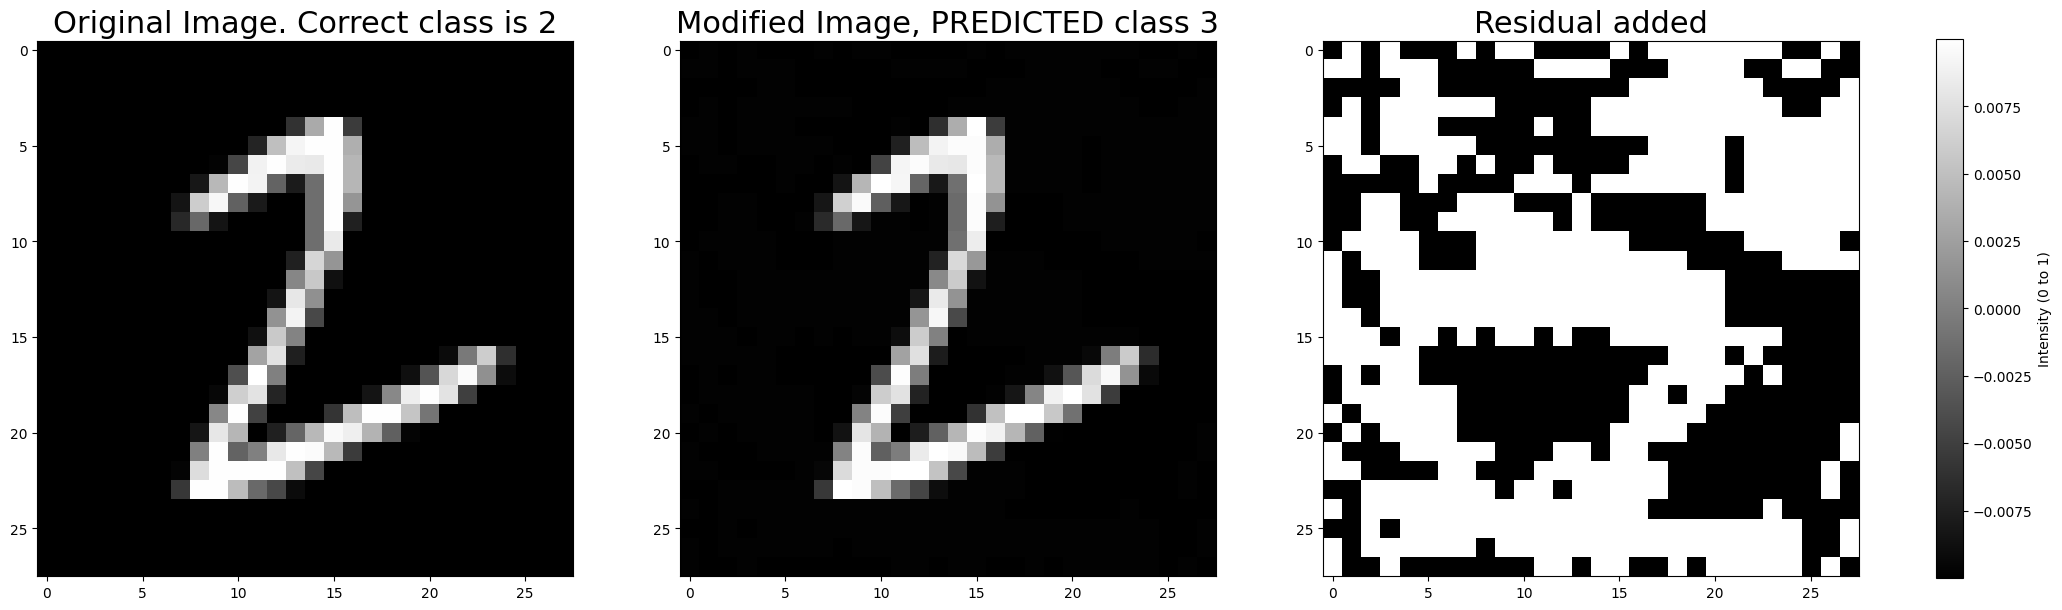


Epsilon = 0.1: Original class: 7, Perturbed class: 3


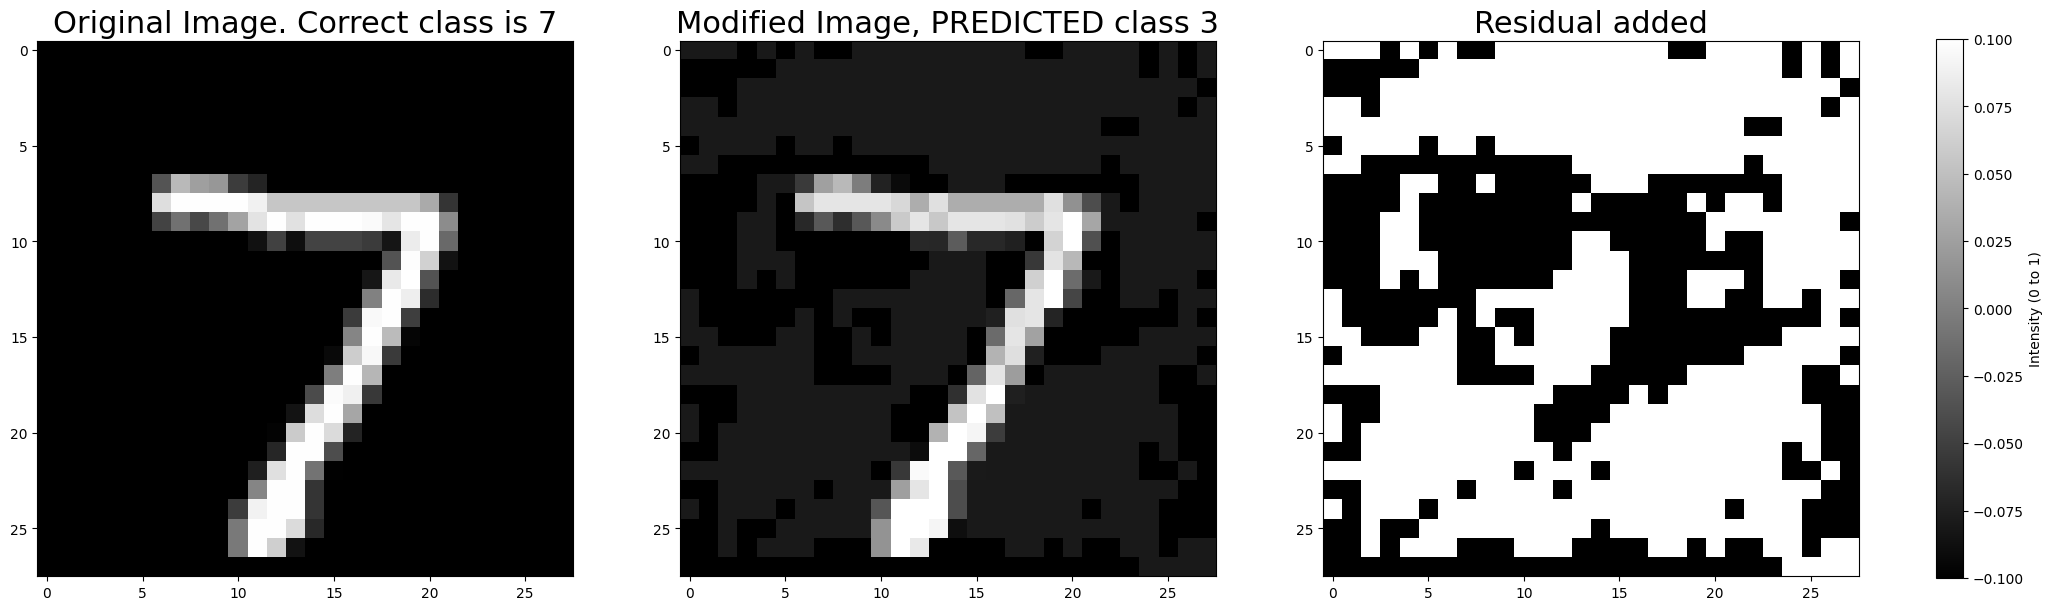


Epsilon = 0.2: Original class: 7, Perturbed class: 3


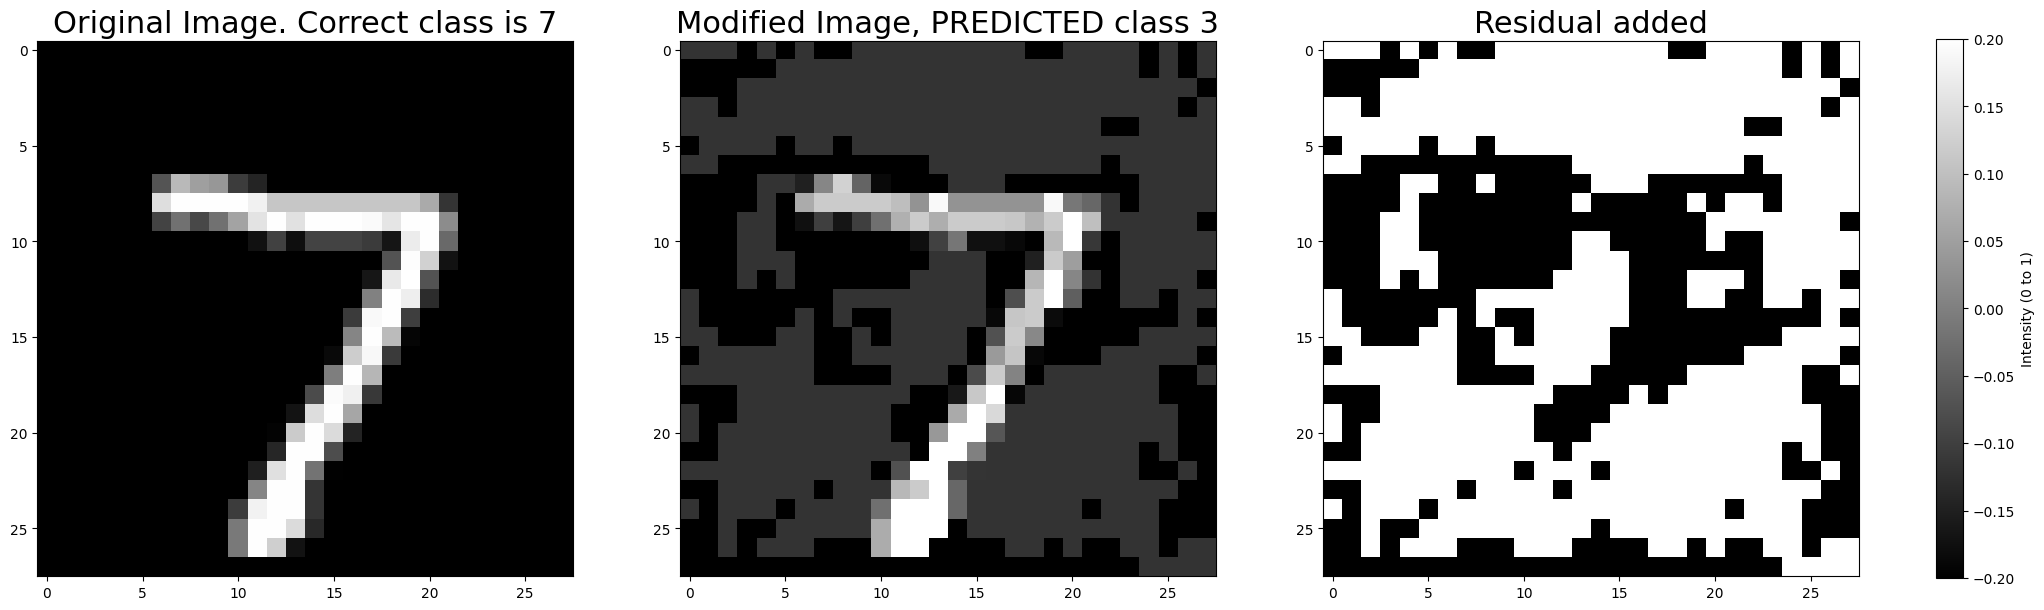


Epsilon = 0.25: Original class: 7, Perturbed class: 3


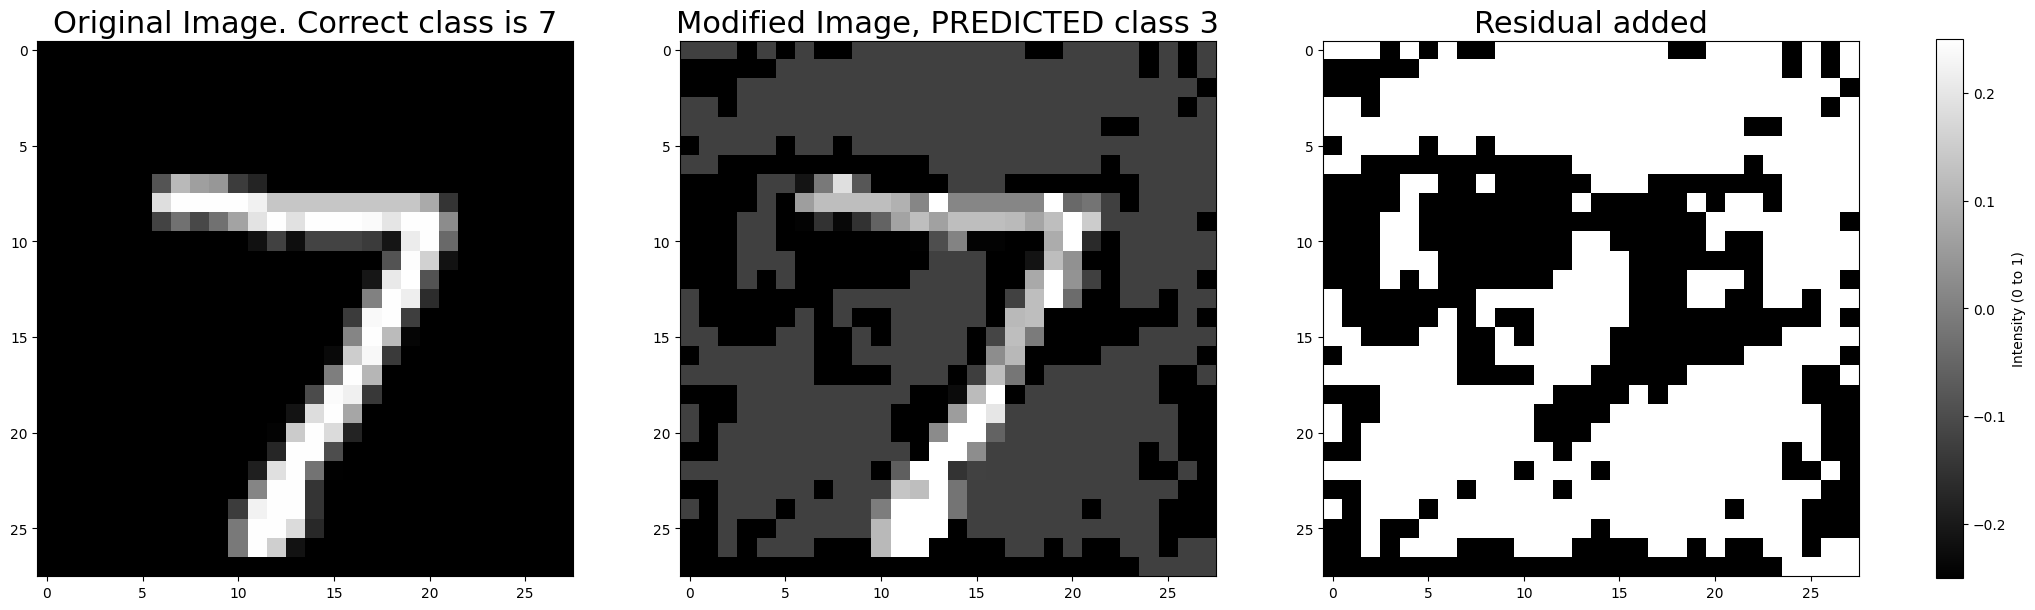


Epsilon = 0.5: Original class: 7, Perturbed class: 3


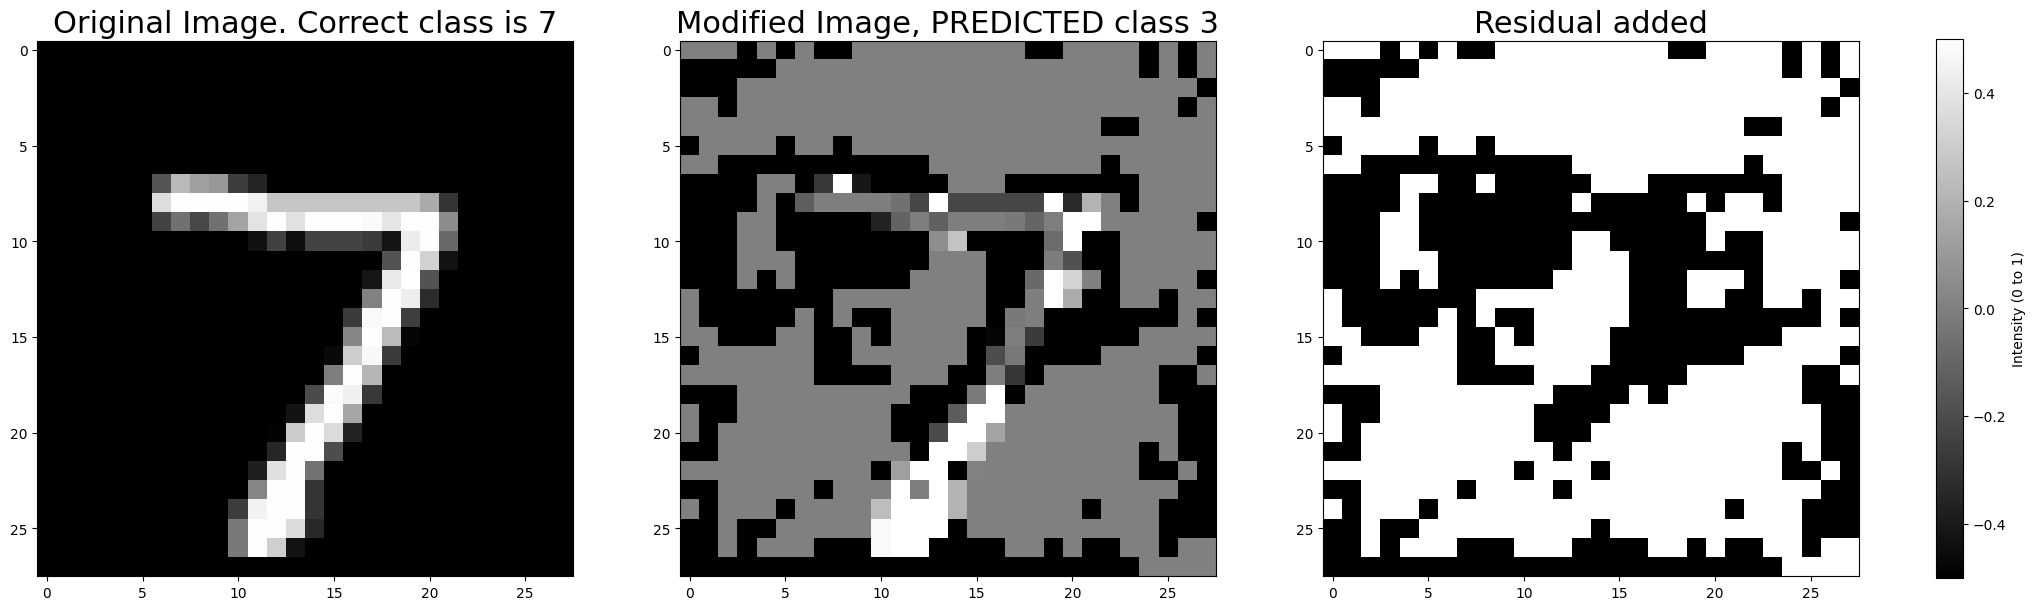


Epsilon = 1: Original class: 7, Perturbed class: 3


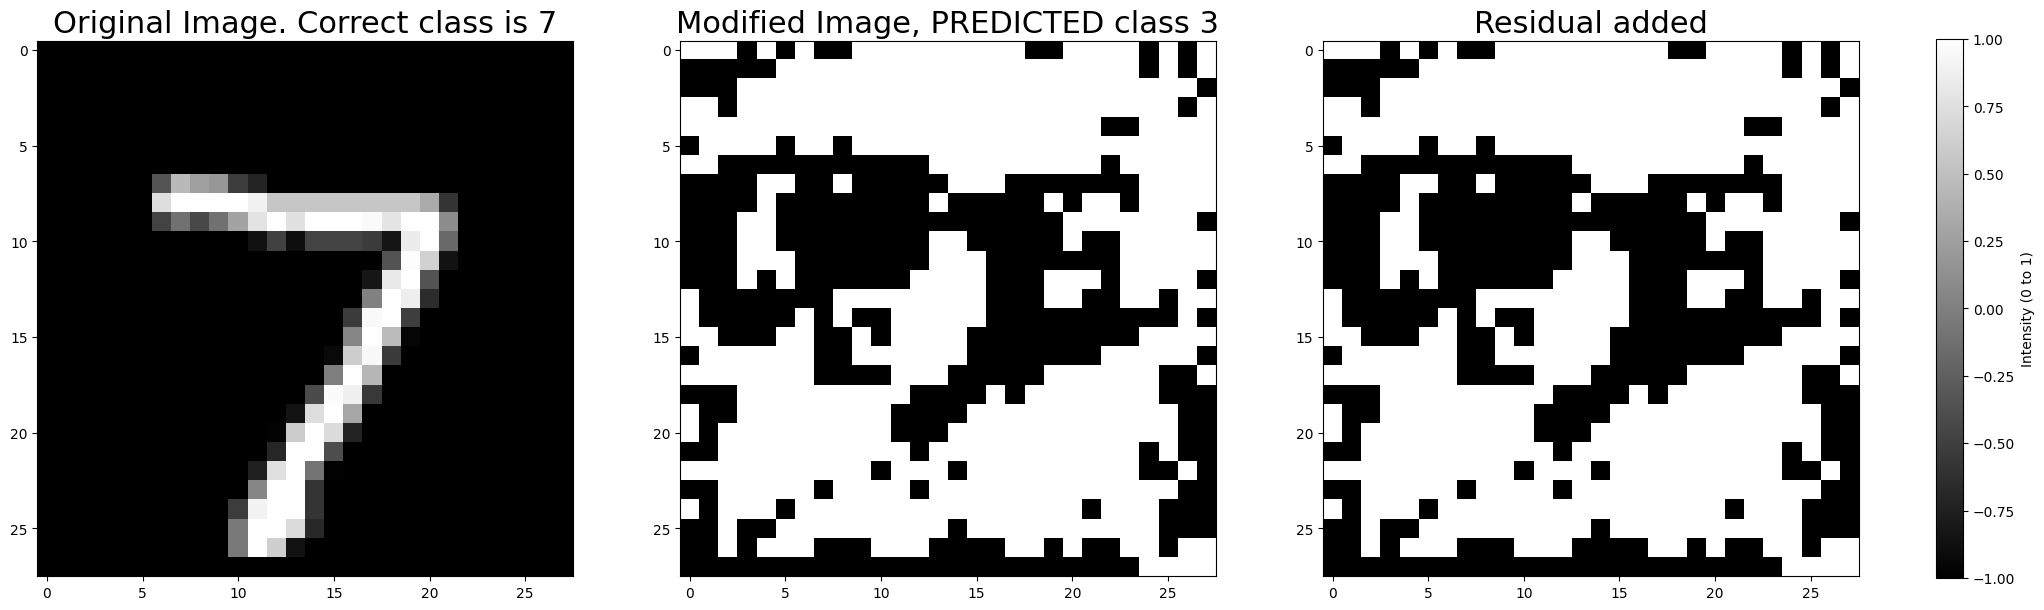


Epsilon = 1.5: Original class: 7, Perturbed class: 3


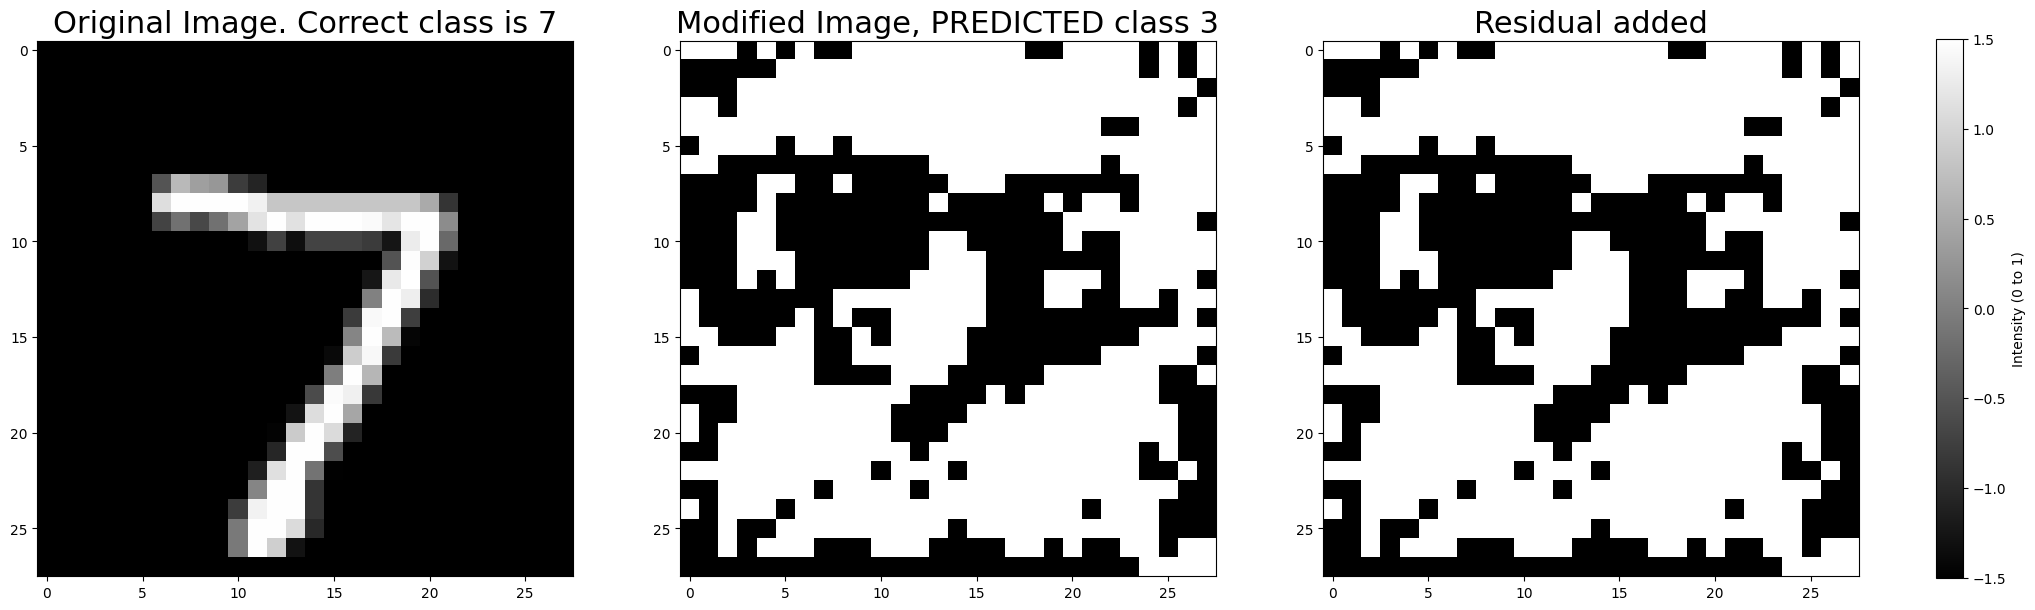

In [71]:
# Accuracy counter
success_per_epsilon = []  # To store a successful adversarial example for each epsilon
eps_values = [0.01, 0.1, 0.2, 0.25, 0.5,1,1.5]  # List of epsilon values to test
loss_model = nn.CrossEntropyLoss()  # Loss function

# Loop over all epsilon values
for eps in eps_values:
    print(f"\nTesting epsilon: {eps}")
    success_count = 0
    total_count = 0
    saved_example = None  # To save one successful example for each epsilon

    for X_batch, Y_batch in test_loader:  # Iterate through batches
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        for X, Y in zip(X_batch, Y_batch):
            X = X.unsqueeze(0)
            Y = Y.unsqueeze(0)
            Xr, original_class, perturbed_class, r = fgsm_attack(X, Y, model, loss_model, eps)

            # Count successes
            if original_class.item() != perturbed_class.item():
                success_count += 1
                if saved_example is None:  # Save the first successful example for this epsilon
                    saved_example = (X, r, Xr, Y, perturbed_class)

            total_count += 1

    # Calculate success rate for this epsilon
    adv_acc = (success_count / total_count) * 100
    print(f"Using epsilon: {eps}, we successfully created {adv_acc:.2f}% adversarial examples.")

    # Store the saved example if available
    if saved_example is not None:
        success_per_epsilon.append((eps, saved_example))

# Plot one successful example for each epsilon
for eps, (X, r, Xr, Y, perturbed_class) in success_per_epsilon:
    print(f"\nEpsilon = {eps}: Original class: {Y.item()}, Perturbed class: {perturbed_class.item()}")
    plot_results(
        X=X.squeeze(),
        r=r.squeeze(),
        Xr=Xr.squeeze(),
        Y=Y.item(),
        l=perturbed_class,
        fail=False
    )


As $\epsilon$ increases, FGSM attacks achieve higher success rates, about  98.43% for $\epsilon > 1$. However, this comes at the cost of image quality.

For $\epsilon \leq 0.25$, the perturbations are still subtle, and the label remains easily recognizable, making these adversarial examples more practical and realistic. Beyond for greater epsilons, the image becomes completely unrecognizable, with chaotic pixels.

An $\epsilon = 0.2$ is a good choice as it balances success and image quality. The adversarial examples are effective while the distortions remain subtle and the image recognizable.